In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn import preprocessing


C:\Users\xia\AppData\Local\Temp\ipykernel_8652\1157685092.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\xia\AppData\Local\Temp\ipykernel_8652\1157685092.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [12]:
def getData(filename, remove_duplicata = True):
    with open(filename) as f:
        df = pd.read_csv(f)
        if remove_duplicata:
            df = df.drop_duplicates()
        X = df.to_numpy()
    return X[:,:-1], X[:,-1]


In [ ]:
def getData2(filename1,filename2, remove_duplicata = True):
    df1 = pd.read_csv(filename1)
    df1.drop(df1.columns[len(df1.columns)-1], axis=1,inplace = True)
    df2 = pd.read_csv(filename2)
    X1 = df1.to_numpy()
    X2 = df2.to_numpy()
    s1, s2 = X1.shape[1], X2.shape[1]
    X11, X12 = X1[:,s1//2:], X1[:,:s1//2]
    X21, X22 = X2[:,s1//2:], X2[:,:s1//2]
    X = np.hstack((X11,X21,X12,X22))
    return X[:,:-1], X[:,-1]

In [13]:
X, Y = getData("tmpdata/dataSelection.csv")
np.unique(Y)

array(['delWord', 'moveELine', 'moveL', 'moveR', 'moveSLine', 'replace',
       'selectAll', 'selectWR', 'tabbing'], dtype=object)

In [14]:

le = preprocessing.LabelEncoder()

tmp = X[:,X.shape[1]//2:]
anotherX = X[:,:X.shape[1]//2]-tmp
anotherX = anotherX.astype('int64')
#anotherX = normalize(anotherX)
le.fit(Y)
Ynum = le.transform(Y)

In [15]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(anotherX),torch.Tensor(Ynum).type(torch.LongTensor))
dataset[1]

(tensor([2., 0., 2., 0., 2., 2., 2.]), tensor(0))

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_tanH_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(np.unique(Y)))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_tanH_stack(x)
        return logits


In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [24]:
epochs = 200

for i in range(5):
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    print("CrossValidation : "+str(i)+"\n-------------------------------\n")
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


    # Create the data loaders for training and validation
    train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=1,
        shuffle=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=1,
        shuffle=False
    )
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        #test(test_dataloader, model, loss_fn)
        test(test_dataloader, model, loss_fn)
    print("Done!")

CrossValidation : 0
-------------------------------

Epoch 1
-------------------------------
loss: 2.104867  [    1/ 5983]
loss: 2.237852  [  101/ 5983]
loss: 1.972467  [  201/ 5983]
loss: 2.217904  [  301/ 5983]
loss: 1.794987  [  401/ 5983]
loss: 0.464098  [  501/ 5983]
loss: 2.099673  [  601/ 5983]
loss: 2.112865  [  701/ 5983]
loss: 1.869657  [  801/ 5983]
loss: 2.037177  [  901/ 5983]
loss: 1.475061  [ 1001/ 5983]
loss: 2.239598  [ 1101/ 5983]
loss: 0.281880  [ 1201/ 5983]
loss: 1.827482  [ 1301/ 5983]
loss: 1.917505  [ 1401/ 5983]
loss: 2.268586  [ 1501/ 5983]
loss: 1.902410  [ 1601/ 5983]
loss: 2.198040  [ 1701/ 5983]
loss: 2.100139  [ 1801/ 5983]
loss: 1.922736  [ 1901/ 5983]
loss: 1.633311  [ 2001/ 5983]
loss: 2.126165  [ 2101/ 5983]
loss: 1.298164  [ 2201/ 5983]
loss: 1.632033  [ 2301/ 5983]
loss: 1.679717  [ 2401/ 5983]
loss: 2.189914  [ 2501/ 5983]
loss: 1.506540  [ 2601/ 5983]
loss: 1.687998  [ 2701/ 5983]
loss: 1.547096  [ 2801/ 5983]
loss: 1.576748  [ 2901/ 5983]
loss: 4

loss: 0.381544  [ 1801/ 5983]
loss: 1.387536  [ 1901/ 5983]
loss: 0.005576  [ 2001/ 5983]
loss: 0.692133  [ 2101/ 5983]
loss: 0.936906  [ 2201/ 5983]
loss: 0.003519  [ 2301/ 5983]
loss: 0.164725  [ 2401/ 5983]
loss: 1.126290  [ 2501/ 5983]
loss: 0.063117  [ 2601/ 5983]
loss: 0.089978  [ 2701/ 5983]
loss: 0.086430  [ 2801/ 5983]
loss: 1.441475  [ 2901/ 5983]
loss: 0.765485  [ 3001/ 5983]
loss: 0.151828  [ 3101/ 5983]
loss: 0.647856  [ 3201/ 5983]
loss: 0.117523  [ 3301/ 5983]
loss: 0.150502  [ 3401/ 5983]
loss: 1.103288  [ 3501/ 5983]
loss: 0.083765  [ 3601/ 5983]
loss: 0.109248  [ 3701/ 5983]
loss: 0.204724  [ 3801/ 5983]
loss: 0.271958  [ 3901/ 5983]
loss: 0.194998  [ 4001/ 5983]
loss: 0.378239  [ 4101/ 5983]
loss: 0.158345  [ 4201/ 5983]
loss: 0.180638  [ 4301/ 5983]
loss: 0.115364  [ 4401/ 5983]
loss: 0.824951  [ 4501/ 5983]
loss: 0.209989  [ 4601/ 5983]
loss: 0.021465  [ 4701/ 5983]
loss: 1.279437  [ 4801/ 5983]
loss: 0.107967  [ 4901/ 5983]
loss: 0.264974  [ 5001/ 5983]
loss: 1.18

loss: 0.072361  [ 4001/ 5983]
loss: 0.010775  [ 4101/ 5983]
loss: 0.021437  [ 4201/ 5983]
loss: 0.832340  [ 4301/ 5983]
loss: 0.356842  [ 4401/ 5983]
loss: 0.056785  [ 4501/ 5983]
loss: 5.196021  [ 4601/ 5983]
loss: 0.664413  [ 4701/ 5983]
loss: 0.035619  [ 4801/ 5983]
loss: 0.568350  [ 4901/ 5983]
loss: 0.698780  [ 5001/ 5983]
loss: 0.000000  [ 5101/ 5983]
loss: 1.050636  [ 5201/ 5983]
loss: 2.063143  [ 5301/ 5983]
loss: 1.089116  [ 5401/ 5983]
loss: 0.020848  [ 5501/ 5983]
loss: 0.427824  [ 5601/ 5983]
loss: 0.020273  [ 5701/ 5983]
loss: 0.243166  [ 5801/ 5983]
loss: 0.006701  [ 5901/ 5983]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.480982 

Epoch 10
-------------------------------
loss: 1.265818  [    1/ 5983]
loss: 1.277340  [  101/ 5983]
loss: 0.021249  [  201/ 5983]
loss: 0.017842  [  301/ 5983]
loss: 0.967198  [  401/ 5983]
loss: 0.445917  [  501/ 5983]
loss: 0.022007  [  601/ 5983]
loss: 0.293283  [  701/ 5983]
loss: 0.237569  [  801/ 5983]
loss: 0.079937  [  901/ 5983]
loss: 6

loss: 0.060513  [  301/ 5983]
loss: 0.294951  [  401/ 5983]
loss: 0.976500  [  501/ 5983]
loss: 0.003968  [  601/ 5983]
loss: 0.037814  [  701/ 5983]
loss: 0.482623  [  801/ 5983]
loss: 0.009784  [  901/ 5983]
loss: 0.001227  [ 1001/ 5983]
loss: 0.767420  [ 1101/ 5983]
loss: 0.025240  [ 1201/ 5983]
loss: 0.526675  [ 1301/ 5983]
loss: 0.073311  [ 1401/ 5983]
loss: 0.037544  [ 1501/ 5983]
loss: 0.631921  [ 1601/ 5983]
loss: 0.003076  [ 1701/ 5983]
loss: 0.018476  [ 1801/ 5983]
loss: 0.001876  [ 1901/ 5983]
loss: 1.104944  [ 2001/ 5983]
loss: 0.717622  [ 2101/ 5983]
loss: 0.121644  [ 2201/ 5983]
loss: 0.888162  [ 2301/ 5983]
loss: 0.492874  [ 2401/ 5983]
loss: 0.000006  [ 2501/ 5983]
loss: 0.014243  [ 2601/ 5983]
loss: 0.914654  [ 2701/ 5983]
loss: 1.097615  [ 2801/ 5983]
loss: 0.001697  [ 2901/ 5983]
loss: 0.019565  [ 3001/ 5983]
loss: 0.017709  [ 3101/ 5983]
loss: 0.531126  [ 3201/ 5983]
loss: 0.000009  [ 3301/ 5983]
loss: 0.000446  [ 3401/ 5983]
loss: 0.680714  [ 3501/ 5983]
loss: 0.00

loss: 0.005317  [ 2401/ 5983]
loss: 1.546861  [ 2501/ 5983]
loss: 0.000179  [ 2601/ 5983]
loss: 0.692860  [ 2701/ 5983]
loss: 0.518107  [ 2801/ 5983]
loss: 0.014175  [ 2901/ 5983]
loss: 0.263859  [ 3001/ 5983]
loss: 0.000001  [ 3101/ 5983]
loss: 0.046153  [ 3201/ 5983]
loss: 0.022817  [ 3301/ 5983]
loss: 0.000421  [ 3401/ 5983]
loss: 0.018170  [ 3501/ 5983]
loss: 1.933007  [ 3601/ 5983]
loss: 0.281714  [ 3701/ 5983]
loss: 0.018174  [ 3801/ 5983]
loss: 0.529790  [ 3901/ 5983]
loss: 0.018748  [ 4001/ 5983]
loss: 0.011335  [ 4101/ 5983]
loss: 1.275771  [ 4201/ 5983]
loss: 0.092865  [ 4301/ 5983]
loss: 2.088026  [ 4401/ 5983]
loss: 0.584035  [ 4501/ 5983]
loss: 0.080044  [ 4601/ 5983]
loss: 0.127081  [ 4701/ 5983]
loss: 0.210957  [ 4801/ 5983]
loss: 0.804841  [ 4901/ 5983]
loss: 0.076532  [ 5001/ 5983]
loss: 0.000093  [ 5101/ 5983]
loss: 0.014622  [ 5201/ 5983]
loss: 0.065849  [ 5301/ 5983]
loss: 0.895326  [ 5401/ 5983]
loss: 0.000044  [ 5501/ 5983]
loss: 0.865952  [ 5601/ 5983]
loss: 0.00

loss: 1.387587  [ 4501/ 5983]
loss: 0.076839  [ 4601/ 5983]
loss: 0.067504  [ 4701/ 5983]
loss: 0.065268  [ 4801/ 5983]
loss: 0.409459  [ 4901/ 5983]
loss: 0.554062  [ 5001/ 5983]
loss: 0.008954  [ 5101/ 5983]
loss: 0.007208  [ 5201/ 5983]
loss: 0.405115  [ 5301/ 5983]
loss: 1.192271  [ 5401/ 5983]
loss: 0.829497  [ 5501/ 5983]
loss: 0.024175  [ 5601/ 5983]
loss: 0.000021  [ 5701/ 5983]
loss: 0.951673  [ 5801/ 5983]
loss: 0.390114  [ 5901/ 5983]
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.527279 

Epoch 23
-------------------------------
loss: 0.744479  [    1/ 5983]
loss: 0.026272  [  101/ 5983]
loss: 0.000001  [  201/ 5983]
loss: 0.009448  [  301/ 5983]
loss: 0.000033  [  401/ 5983]
loss: 0.461776  [  501/ 5983]
loss: 0.694336  [  601/ 5983]
loss: 0.365239  [  701/ 5983]
loss: 0.054670  [  801/ 5983]
loss: 0.826715  [  901/ 5983]
loss: 0.000154  [ 1001/ 5983]
loss: 0.984151  [ 1101/ 5983]
loss: 0.005691  [ 1201/ 5983]
loss: 0.010451  [ 1301/ 5983]
loss: 0.613935  [ 1401/ 5983]
loss: 0

loss: 0.807535  [  301/ 5983]
loss: 0.005732  [  401/ 5983]
loss: 0.115206  [  501/ 5983]
loss: 0.000001  [  601/ 5983]
loss: 0.005096  [  701/ 5983]
loss: 0.100612  [  801/ 5983]
loss: 0.018279  [  901/ 5983]
loss: 0.658436  [ 1001/ 5983]
loss: 0.007041  [ 1101/ 5983]
loss: 0.022643  [ 1201/ 5983]
loss: 0.898931  [ 1301/ 5983]
loss: 0.000151  [ 1401/ 5983]
loss: 0.678177  [ 1501/ 5983]
loss: 0.011433  [ 1601/ 5983]
loss: 0.000011  [ 1701/ 5983]
loss: 0.091370  [ 1801/ 5983]
loss: 0.011183  [ 1901/ 5983]
loss: 0.437712  [ 2001/ 5983]
loss: 0.023699  [ 2101/ 5983]
loss: 0.285828  [ 2201/ 5983]
loss: 0.017013  [ 2301/ 5983]
loss: 0.015522  [ 2401/ 5983]
loss: 0.753780  [ 2501/ 5983]
loss: 0.000000  [ 2601/ 5983]
loss: 1.254131  [ 2701/ 5983]
loss: 3.643872  [ 2801/ 5983]
loss: 0.252336  [ 2901/ 5983]
loss: 0.000000  [ 3001/ 5983]
loss: 3.377321  [ 3101/ 5983]
loss: 0.003692  [ 3201/ 5983]
loss: 0.097909  [ 3301/ 5983]
loss: 0.006289  [ 3401/ 5983]
loss: 0.002894  [ 3501/ 5983]
loss: 0.55

loss: 0.000985  [ 2401/ 5983]
loss: 0.067266  [ 2501/ 5983]
loss: 0.009109  [ 2601/ 5983]
loss: 0.003193  [ 2701/ 5983]
loss: 0.690236  [ 2801/ 5983]
loss: 0.725148  [ 2901/ 5983]
loss: 0.130386  [ 3001/ 5983]
loss: 0.071476  [ 3101/ 5983]
loss: 0.033109  [ 3201/ 5983]
loss: 0.005737  [ 3301/ 5983]
loss: 0.000002  [ 3401/ 5983]
loss: 1.520173  [ 3501/ 5983]
loss: 0.762425  [ 3601/ 5983]
loss: 0.004988  [ 3701/ 5983]
loss: 0.000023  [ 3801/ 5983]
loss: 0.004508  [ 3901/ 5983]
loss: 0.029344  [ 4001/ 5983]
loss: 0.005773  [ 4101/ 5983]
loss: 0.706074  [ 4201/ 5983]
loss: 0.038531  [ 4301/ 5983]
loss: 0.674435  [ 4401/ 5983]
loss: 0.945576  [ 4501/ 5983]
loss: 0.103359  [ 4601/ 5983]
loss: 0.746570  [ 4701/ 5983]
loss: 0.005182  [ 4801/ 5983]
loss: 0.001458  [ 4901/ 5983]
loss: 0.729572  [ 5001/ 5983]
loss: 0.006710  [ 5101/ 5983]
loss: 0.000909  [ 5201/ 5983]
loss: 0.787069  [ 5301/ 5983]
loss: 0.001279  [ 5401/ 5983]
loss: 1.525779  [ 5501/ 5983]
loss: 0.052447  [ 5601/ 5983]
loss: 0.16

loss: 0.000000  [ 4501/ 5983]
loss: 0.750150  [ 4601/ 5983]
loss: 0.566243  [ 4701/ 5983]
loss: 0.617577  [ 4801/ 5983]
loss: 0.060726  [ 4901/ 5983]
loss: 0.201015  [ 5001/ 5983]
loss: 0.002959  [ 5101/ 5983]
loss: 0.115379  [ 5201/ 5983]
loss: 0.013703  [ 5301/ 5983]
loss: 0.000000  [ 5401/ 5983]
loss: 0.981126  [ 5501/ 5983]
loss: 0.000027  [ 5601/ 5983]
loss: 0.081014  [ 5701/ 5983]
loss: 0.000037  [ 5801/ 5983]
loss: 0.910120  [ 5901/ 5983]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.354495 

Epoch 36
-------------------------------
loss: 0.425599  [    1/ 5983]
loss: 0.000012  [  101/ 5983]
loss: 0.072613  [  201/ 5983]
loss: 0.000005  [  301/ 5983]
loss: 0.030697  [  401/ 5983]
loss: 0.343438  [  501/ 5983]
loss: 0.701935  [  601/ 5983]
loss: 0.788194  [  701/ 5983]
loss: 0.003329  [  801/ 5983]
loss: 1.095602  [  901/ 5983]
loss: 0.084971  [ 1001/ 5983]
loss: 0.049839  [ 1101/ 5983]
loss: 0.420245  [ 1201/ 5983]
loss: 0.000707  [ 1301/ 5983]
loss: 0.011856  [ 1401/ 5983]
loss: 0

loss: 0.004790  [  301/ 5983]
loss: 0.462771  [  401/ 5983]
loss: 0.003705  [  501/ 5983]
loss: 3.360955  [  601/ 5983]
loss: 0.202011  [  701/ 5983]
loss: 0.337116  [  801/ 5983]
loss: 1.458332  [  901/ 5983]
loss: 1.297671  [ 1001/ 5983]
loss: 0.003528  [ 1101/ 5983]
loss: 0.061441  [ 1201/ 5983]
loss: 0.003536  [ 1301/ 5983]
loss: 0.351511  [ 1401/ 5983]
loss: 0.599420  [ 1501/ 5983]
loss: 0.012169  [ 1601/ 5983]
loss: 0.000002  [ 1701/ 5983]
loss: 0.000890  [ 1801/ 5983]
loss: 0.071813  [ 1901/ 5983]
loss: 0.073059  [ 2001/ 5983]
loss: 0.000172  [ 2101/ 5983]
loss: 0.000003  [ 2201/ 5983]
loss: 0.050071  [ 2301/ 5983]
loss: 3.282660  [ 2401/ 5983]
loss: 0.646079  [ 2501/ 5983]
loss: 0.000035  [ 2601/ 5983]
loss: 0.000661  [ 2701/ 5983]
loss: 0.080556  [ 2801/ 5983]
loss: 0.000000  [ 2901/ 5983]
loss: 0.009399  [ 3001/ 5983]
loss: 0.000000  [ 3101/ 5983]
loss: 0.663452  [ 3201/ 5983]
loss: 0.309937  [ 3301/ 5983]
loss: 0.514746  [ 3401/ 5983]
loss: 0.000001  [ 3501/ 5983]
loss: 2.17

loss: 0.000008  [ 2401/ 5983]
loss: 0.120363  [ 2501/ 5983]
loss: 0.112442  [ 2601/ 5983]
loss: 0.850472  [ 2701/ 5983]
loss: 0.490444  [ 2801/ 5983]
loss: 1.195297  [ 2901/ 5983]
loss: 0.900316  [ 3001/ 5983]
loss: 0.819565  [ 3101/ 5983]
loss: 0.015729  [ 3201/ 5983]
loss: 0.000083  [ 3301/ 5983]
loss: 0.005037  [ 3401/ 5983]
loss: 0.173325  [ 3501/ 5983]
loss: 0.000000  [ 3601/ 5983]
loss: 0.424585  [ 3701/ 5983]
loss: 0.229691  [ 3801/ 5983]
loss: 0.007509  [ 3901/ 5983]
loss: 0.122316  [ 4001/ 5983]
loss: 0.071762  [ 4101/ 5983]
loss: 1.012084  [ 4201/ 5983]
loss: 0.014983  [ 4301/ 5983]
loss: 1.028755  [ 4401/ 5983]
loss: 0.106849  [ 4501/ 5983]
loss: 0.000035  [ 4601/ 5983]
loss: 1.033288  [ 4701/ 5983]
loss: 0.064503  [ 4801/ 5983]
loss: 0.069679  [ 4901/ 5983]
loss: 0.524770  [ 5001/ 5983]
loss: 0.519537  [ 5101/ 5983]
loss: 0.003950  [ 5201/ 5983]
loss: 0.000292  [ 5301/ 5983]
loss: 2.510682  [ 5401/ 5983]
loss: 0.007852  [ 5501/ 5983]
loss: 0.006099  [ 5601/ 5983]
loss: 0.01

loss: 0.000001  [ 4501/ 5983]
loss: 0.016917  [ 4601/ 5983]
loss: 0.786533  [ 4701/ 5983]
loss: 0.010915  [ 4801/ 5983]
loss: 0.574109  [ 4901/ 5983]
loss: 0.008619  [ 5001/ 5983]
loss: 0.000236  [ 5101/ 5983]
loss: 0.213392  [ 5201/ 5983]
loss: 0.698130  [ 5301/ 5983]
loss: 0.000014  [ 5401/ 5983]
loss: 0.000014  [ 5501/ 5983]
loss: 0.110935  [ 5601/ 5983]
loss: 0.952769  [ 5701/ 5983]
loss: 0.000000  [ 5801/ 5983]
loss: 0.118872  [ 5901/ 5983]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.290323 

Epoch 49
-------------------------------
loss: 0.555603  [    1/ 5983]
loss: 0.000000  [  101/ 5983]
loss: 0.083597  [  201/ 5983]
loss: 0.027749  [  301/ 5983]
loss: 0.095864  [  401/ 5983]
loss: 0.000004  [  501/ 5983]
loss: 0.306036  [  601/ 5983]
loss: 0.024474  [  701/ 5983]
loss: 0.892555  [  801/ 5983]
loss: 0.006384  [  901/ 5983]
loss: 0.076605  [ 1001/ 5983]
loss: 0.033330  [ 1101/ 5983]
loss: 0.020325  [ 1201/ 5983]
loss: 0.834368  [ 1301/ 5983]
loss: 0.000001  [ 1401/ 5983]
loss: 0

loss: 0.012601  [  301/ 5983]
loss: 0.000043  [  401/ 5983]
loss: 0.000010  [  501/ 5983]
loss: 0.645150  [  601/ 5983]
loss: 0.000189  [  701/ 5983]
loss: 0.166167  [  801/ 5983]
loss: 1.118753  [  901/ 5983]
loss: 0.007264  [ 1001/ 5983]
loss: 0.000000  [ 1101/ 5983]
loss: 0.010293  [ 1201/ 5983]
loss: 0.000000  [ 1301/ 5983]
loss: 0.000075  [ 1401/ 5983]
loss: 0.126844  [ 1501/ 5983]
loss: 0.000102  [ 1601/ 5983]
loss: 0.012734  [ 1701/ 5983]
loss: 0.009849  [ 1801/ 5983]
loss: 0.004207  [ 1901/ 5983]
loss: 0.289598  [ 2001/ 5983]
loss: 0.643452  [ 2101/ 5983]
loss: 0.551831  [ 2201/ 5983]
loss: 0.010993  [ 2301/ 5983]
loss: 0.004749  [ 2401/ 5983]
loss: 0.004891  [ 2501/ 5983]
loss: 0.732726  [ 2601/ 5983]
loss: 0.003774  [ 2701/ 5983]
loss: 0.000001  [ 2801/ 5983]
loss: 0.071162  [ 2901/ 5983]
loss: 0.095853  [ 3001/ 5983]
loss: 0.009737  [ 3101/ 5983]
loss: 0.000681  [ 3201/ 5983]
loss: 0.751253  [ 3301/ 5983]
loss: 0.000000  [ 3401/ 5983]
loss: 0.188964  [ 3501/ 5983]
loss: 0.90

loss: 0.003495  [ 2401/ 5983]
loss: 0.173258  [ 2501/ 5983]
loss: 0.054415  [ 2601/ 5983]
loss: 0.000056  [ 2701/ 5983]
loss: 0.003147  [ 2801/ 5983]
loss: 0.000545  [ 2901/ 5983]
loss: 0.000003  [ 3001/ 5983]
loss: 0.001761  [ 3101/ 5983]
loss: 0.909674  [ 3201/ 5983]
loss: 0.002210  [ 3301/ 5983]
loss: 0.002867  [ 3401/ 5983]
loss: 5.932335  [ 3501/ 5983]
loss: 0.040589  [ 3601/ 5983]
loss: 0.007602  [ 3701/ 5983]
loss: 0.004232  [ 3801/ 5983]
loss: 0.282254  [ 3901/ 5983]
loss: 0.003910  [ 4001/ 5983]
loss: 0.000000  [ 4101/ 5983]
loss: 0.036396  [ 4201/ 5983]
loss: 0.787779  [ 4301/ 5983]
loss: 0.310417  [ 4401/ 5983]
loss: 0.012769  [ 4501/ 5983]
loss: 0.004790  [ 4601/ 5983]
loss: 0.813999  [ 4701/ 5983]
loss: 0.000014  [ 4801/ 5983]
loss: 0.005055  [ 4901/ 5983]
loss: 0.078274  [ 5001/ 5983]
loss: 0.074006  [ 5101/ 5983]
loss: 1.335569  [ 5201/ 5983]
loss: 0.879670  [ 5301/ 5983]
loss: 1.489911  [ 5401/ 5983]
loss: 0.000000  [ 5501/ 5983]
loss: 0.485571  [ 5601/ 5983]
loss: 0.78

loss: 0.691275  [ 4501/ 5983]
loss: 0.002651  [ 4601/ 5983]
loss: 1.454278  [ 4701/ 5983]
loss: 0.747363  [ 4801/ 5983]
loss: 0.012207  [ 4901/ 5983]
loss: 0.012866  [ 5001/ 5983]
loss: 1.318915  [ 5101/ 5983]
loss: 0.000364  [ 5201/ 5983]
loss: 0.375825  [ 5301/ 5983]
loss: 0.046294  [ 5401/ 5983]
loss: 0.000000  [ 5501/ 5983]
loss: 0.059151  [ 5601/ 5983]
loss: 0.789692  [ 5701/ 5983]
loss: 1.035232  [ 5801/ 5983]
loss: 0.000020  [ 5901/ 5983]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.307197 

Epoch 62
-------------------------------
loss: 0.009573  [    1/ 5983]
loss: 0.615269  [  101/ 5983]
loss: 0.000005  [  201/ 5983]
loss: 0.006384  [  301/ 5983]
loss: 1.230189  [  401/ 5983]
loss: 0.314994  [  501/ 5983]
loss: 0.060433  [  601/ 5983]
loss: 0.056431  [  701/ 5983]
loss: 0.729024  [  801/ 5983]
loss: 0.004466  [  901/ 5983]
loss: 0.004163  [ 1001/ 5983]
loss: 0.628830  [ 1101/ 5983]
loss: 0.000000  [ 1201/ 5983]
loss: 0.095895  [ 1301/ 5983]
loss: 3.008299  [ 1401/ 5983]
loss: 0

loss: 0.007963  [  301/ 5983]
loss: 0.118208  [  401/ 5983]
loss: 0.000009  [  501/ 5983]
loss: 0.426676  [  601/ 5983]
loss: 0.013799  [  701/ 5983]
loss: 0.001551  [  801/ 5983]
loss: 0.007843  [  901/ 5983]
loss: 0.534950  [ 1001/ 5983]
loss: 0.150123  [ 1101/ 5983]
loss: 0.000001  [ 1201/ 5983]
loss: 0.000003  [ 1301/ 5983]
loss: 0.530870  [ 1401/ 5983]
loss: 1.881445  [ 1501/ 5983]
loss: 0.003942  [ 1601/ 5983]
loss: 0.815637  [ 1701/ 5983]
loss: 0.005116  [ 1801/ 5983]
loss: 0.006303  [ 1901/ 5983]
loss: 0.001929  [ 2001/ 5983]
loss: 0.000253  [ 2101/ 5983]
loss: 0.000201  [ 2201/ 5983]
loss: 0.005119  [ 2301/ 5983]
loss: 0.829125  [ 2401/ 5983]
loss: 0.090133  [ 2501/ 5983]
loss: 0.002217  [ 2601/ 5983]
loss: 0.000001  [ 2701/ 5983]
loss: 0.058644  [ 2801/ 5983]
loss: 0.005364  [ 2901/ 5983]
loss: 0.944774  [ 3001/ 5983]
loss: 0.005206  [ 3101/ 5983]
loss: 0.010930  [ 3201/ 5983]
loss: 0.992500  [ 3301/ 5983]
loss: 0.001784  [ 3401/ 5983]
loss: 0.742890  [ 3501/ 5983]
loss: 1.04

loss: 0.001779  [ 2401/ 5983]
loss: 0.000130  [ 2501/ 5983]
loss: 0.001465  [ 2601/ 5983]
loss: 0.832493  [ 2701/ 5983]
loss: 0.673967  [ 2801/ 5983]
loss: 0.087179  [ 2901/ 5983]
loss: 0.000193  [ 3001/ 5983]
loss: 0.307487  [ 3101/ 5983]
loss: 5.329698  [ 3201/ 5983]
loss: 1.465169  [ 3301/ 5983]
loss: 0.000000  [ 3401/ 5983]
loss: 0.459465  [ 3501/ 5983]
loss: 0.053195  [ 3601/ 5983]
loss: 0.000838  [ 3701/ 5983]
loss: 0.644782  [ 3801/ 5983]
loss: 0.854667  [ 3901/ 5983]
loss: 0.033354  [ 4001/ 5983]
loss: 0.036201  [ 4101/ 5983]
loss: 0.099720  [ 4201/ 5983]
loss: 2.993949  [ 4301/ 5983]
loss: 1.741338  [ 4401/ 5983]
loss: 0.008480  [ 4501/ 5983]
loss: 0.000002  [ 4601/ 5983]
loss: 1.092666  [ 4701/ 5983]
loss: 0.008111  [ 4801/ 5983]
loss: 0.772353  [ 4901/ 5983]
loss: 0.046029  [ 5001/ 5983]
loss: 0.000011  [ 5101/ 5983]
loss: 0.064240  [ 5201/ 5983]
loss: 0.005374  [ 5301/ 5983]
loss: 0.623188  [ 5401/ 5983]
loss: 0.043124  [ 5501/ 5983]
loss: 0.911234  [ 5601/ 5983]
loss: 0.59

loss: 0.700984  [ 4501/ 5983]
loss: 0.000012  [ 4601/ 5983]
loss: 0.006073  [ 4701/ 5983]
loss: 0.067053  [ 4801/ 5983]
loss: 1.048267  [ 4901/ 5983]
loss: 0.240122  [ 5001/ 5983]
loss: 1.330381  [ 5101/ 5983]
loss: 0.101406  [ 5201/ 5983]
loss: 0.429049  [ 5301/ 5983]
loss: 1.178336  [ 5401/ 5983]
loss: 0.000956  [ 5501/ 5983]
loss: 0.009903  [ 5601/ 5983]
loss: 2.379878  [ 5701/ 5983]
loss: 0.075159  [ 5801/ 5983]
loss: 0.700055  [ 5901/ 5983]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.289756 

Epoch 75
-------------------------------
loss: 0.646596  [    1/ 5983]
loss: 0.005490  [  101/ 5983]
loss: 0.001101  [  201/ 5983]
loss: 0.039223  [  301/ 5983]
loss: 0.686930  [  401/ 5983]
loss: 0.001768  [  501/ 5983]
loss: 0.000000  [  601/ 5983]
loss: 1.255477  [  701/ 5983]
loss: 0.073139  [  801/ 5983]
loss: 0.006335  [  901/ 5983]
loss: 0.068731  [ 1001/ 5983]
loss: 0.057846  [ 1101/ 5983]
loss: 0.672042  [ 1201/ 5983]
loss: 0.229614  [ 1301/ 5983]
loss: 0.987481  [ 1401/ 5983]
loss: 0

loss: 0.003863  [  301/ 5983]
loss: 0.004530  [  401/ 5983]
loss: 0.000000  [  501/ 5983]
loss: 0.003467  [  601/ 5983]
loss: 4.005567  [  701/ 5983]
loss: 0.002506  [  801/ 5983]
loss: 0.004433  [  901/ 5983]
loss: 0.000838  [ 1001/ 5983]
loss: 0.003402  [ 1101/ 5983]
loss: 0.003555  [ 1201/ 5983]
loss: 0.584168  [ 1301/ 5983]
loss: 0.441622  [ 1401/ 5983]
loss: 0.001269  [ 1501/ 5983]
loss: 0.820950  [ 1601/ 5983]
loss: 0.061326  [ 1701/ 5983]
loss: 1.367181  [ 1801/ 5983]
loss: 0.000076  [ 1901/ 5983]
loss: 0.628620  [ 2001/ 5983]
loss: 0.092957  [ 2101/ 5983]
loss: 0.082515  [ 2201/ 5983]
loss: 0.764355  [ 2301/ 5983]
loss: 0.007102  [ 2401/ 5983]
loss: 0.006818  [ 2501/ 5983]
loss: 0.759294  [ 2601/ 5983]
loss: 0.058960  [ 2701/ 5983]
loss: 0.005004  [ 2801/ 5983]
loss: 0.540736  [ 2901/ 5983]
loss: 0.000099  [ 3001/ 5983]
loss: 0.577628  [ 3101/ 5983]
loss: 2.627834  [ 3201/ 5983]
loss: 0.055020  [ 3301/ 5983]
loss: 0.000003  [ 3401/ 5983]
loss: 0.458454  [ 3501/ 5983]
loss: 0.00

loss: 0.000011  [ 2401/ 5983]


KeyboardInterrupt: 

In [25]:
epochs = 200


model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


# Create the data loaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=1,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=1,
    shuffle=False
)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.066852  [    1/ 5983]
loss: 2.162317  [  101/ 5983]
loss: 2.270240  [  201/ 5983]
loss: 2.155089  [  301/ 5983]
loss: 1.870262  [  401/ 5983]
loss: 2.214240  [  501/ 5983]
loss: 1.999289  [  601/ 5983]
loss: 0.264427  [  701/ 5983]
loss: 2.033786  [  801/ 5983]
loss: 5.941476  [  901/ 5983]
loss: 2.081666  [ 1001/ 5983]
loss: 2.024679  [ 1101/ 5983]
loss: 1.208957  [ 1201/ 5983]
loss: 2.021038  [ 1301/ 5983]
loss: 1.551514  [ 1401/ 5983]
loss: 2.083002  [ 1501/ 5983]
loss: 1.982641  [ 1601/ 5983]
loss: 1.929574  [ 1701/ 5983]
loss: 1.397302  [ 1801/ 5983]
loss: 1.735736  [ 1901/ 5983]
loss: 1.900647  [ 2001/ 5983]
loss: 2.541202  [ 2101/ 5983]
loss: 1.826088  [ 2201/ 5983]
loss: 0.531949  [ 2301/ 5983]
loss: 1.698306  [ 2401/ 5983]
loss: 1.425292  [ 2501/ 5983]
loss: 1.672283  [ 2601/ 5983]
loss: 2.047601  [ 2701/ 5983]
loss: 1.878390  [ 2801/ 5983]
loss: 1.901050  [ 2901/ 5983]
loss: 2.817936  [ 3001/ 5983]
loss: 1.540917  [ 3101/ 5983]


loss: 0.123836  [ 2101/ 5983]
loss: 0.182522  [ 2201/ 5983]
loss: 1.051290  [ 2301/ 5983]
loss: 0.128021  [ 2401/ 5983]
loss: 0.923757  [ 2501/ 5983]
loss: 0.000015  [ 2601/ 5983]
loss: 0.677267  [ 2701/ 5983]
loss: 0.869696  [ 2801/ 5983]
loss: 1.400181  [ 2901/ 5983]
loss: 1.405005  [ 3001/ 5983]
loss: 0.073936  [ 3101/ 5983]
loss: 0.129135  [ 3201/ 5983]
loss: 0.729597  [ 3301/ 5983]
loss: 0.828182  [ 3401/ 5983]
loss: 0.714194  [ 3501/ 5983]
loss: 0.803414  [ 3601/ 5983]
loss: 0.005740  [ 3701/ 5983]
loss: 0.110893  [ 3801/ 5983]
loss: 0.229735  [ 3901/ 5983]
loss: 0.142288  [ 4001/ 5983]
loss: 0.000415  [ 4101/ 5983]
loss: 1.866001  [ 4201/ 5983]
loss: 2.566135  [ 4301/ 5983]
loss: 0.000075  [ 4401/ 5983]
loss: 1.475146  [ 4501/ 5983]
loss: 0.056698  [ 4601/ 5983]
loss: 0.000391  [ 4701/ 5983]
loss: 0.017013  [ 4801/ 5983]
loss: 0.713614  [ 4901/ 5983]
loss: 0.774252  [ 5001/ 5983]
loss: 0.650040  [ 5101/ 5983]
loss: 0.114697  [ 5201/ 5983]
loss: 0.123769  [ 5301/ 5983]
loss: 0.46

loss: 1.720759  [ 4201/ 5983]
loss: 0.021687  [ 4301/ 5983]
loss: 0.015509  [ 4401/ 5983]
loss: 0.920326  [ 4501/ 5983]
loss: 0.031723  [ 4601/ 5983]
loss: 1.358908  [ 4701/ 5983]
loss: 1.438052  [ 4801/ 5983]
loss: 0.064436  [ 4901/ 5983]
loss: 0.042132  [ 5001/ 5983]
loss: 0.071687  [ 5101/ 5983]
loss: 1.686167  [ 5201/ 5983]
loss: 0.876660  [ 5301/ 5983]
loss: 0.731547  [ 5401/ 5983]
loss: 0.061707  [ 5501/ 5983]
loss: 0.013206  [ 5601/ 5983]
loss: 0.634480  [ 5701/ 5983]
loss: 0.061445  [ 5801/ 5983]
loss: 0.677843  [ 5901/ 5983]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.470467 

Epoch 10
-------------------------------
loss: 0.014336  [    1/ 5983]
loss: 0.449282  [  101/ 5983]
loss: 0.149046  [  201/ 5983]
loss: 0.334559  [  301/ 5983]
loss: 0.244814  [  401/ 5983]
loss: 0.004626  [  501/ 5983]
loss: 0.000004  [  601/ 5983]
loss: 0.029900  [  701/ 5983]
loss: 0.000000  [  801/ 5983]
loss: 0.601732  [  901/ 5983]
loss: 0.446899  [ 1001/ 5983]
loss: 0.019550  [ 1101/ 5983]
loss: 2

loss: 0.000019  [  301/ 5983]
loss: 0.000887  [  401/ 5983]
loss: 0.010758  [  501/ 5983]
loss: 0.590304  [  601/ 5983]
loss: 0.012619  [  701/ 5983]
loss: 0.012989  [  801/ 5983]
loss: 0.024441  [  901/ 5983]
loss: 0.212694  [ 1001/ 5983]
loss: 0.040200  [ 1101/ 5983]
loss: 0.630888  [ 1201/ 5983]
loss: 0.010042  [ 1301/ 5983]
loss: 0.820103  [ 1401/ 5983]
loss: 0.001998  [ 1501/ 5983]
loss: 0.022123  [ 1601/ 5983]
loss: 0.000045  [ 1701/ 5983]
loss: 0.041008  [ 1801/ 5983]
loss: 0.021721  [ 1901/ 5983]
loss: 0.046114  [ 2001/ 5983]
loss: 0.967652  [ 2101/ 5983]
loss: 0.057733  [ 2201/ 5983]
loss: 0.168324  [ 2301/ 5983]
loss: 0.143369  [ 2401/ 5983]
loss: 0.000507  [ 2501/ 5983]
loss: 0.018786  [ 2601/ 5983]
loss: 0.001663  [ 2701/ 5983]
loss: 0.120807  [ 2801/ 5983]
loss: 0.731126  [ 2901/ 5983]
loss: 0.001099  [ 3001/ 5983]
loss: 1.221658  [ 3101/ 5983]
loss: 0.043934  [ 3201/ 5983]
loss: 0.149814  [ 3301/ 5983]
loss: 0.000175  [ 3401/ 5983]
loss: 3.442230  [ 3501/ 5983]
loss: 0.01

loss: 0.001314  [ 2401/ 5983]
loss: 0.018182  [ 2501/ 5983]
loss: 0.010199  [ 2601/ 5983]
loss: 1.100012  [ 2701/ 5983]
loss: 0.773689  [ 2801/ 5983]
loss: 0.309431  [ 2901/ 5983]
loss: 2.045370  [ 3001/ 5983]
loss: 0.265812  [ 3101/ 5983]
loss: 0.396698  [ 3201/ 5983]
loss: 0.898237  [ 3301/ 5983]
loss: 0.650724  [ 3401/ 5983]
loss: 0.825529  [ 3501/ 5983]
loss: 0.006278  [ 3601/ 5983]
loss: 0.000367  [ 3701/ 5983]
loss: 0.600488  [ 3801/ 5983]
loss: 1.607452  [ 3901/ 5983]
loss: 0.050132  [ 4001/ 5983]
loss: 0.002062  [ 4101/ 5983]
loss: 2.151325  [ 4201/ 5983]
loss: 0.126502  [ 4301/ 5983]
loss: 0.818409  [ 4401/ 5983]
loss: 0.301848  [ 4501/ 5983]
loss: 0.003023  [ 4601/ 5983]
loss: 0.009915  [ 4701/ 5983]
loss: 0.075262  [ 4801/ 5983]
loss: 2.184688  [ 4901/ 5983]
loss: 0.069768  [ 5001/ 5983]
loss: 0.015541  [ 5101/ 5983]
loss: 0.568074  [ 5201/ 5983]
loss: 0.020556  [ 5301/ 5983]
loss: 0.008863  [ 5401/ 5983]
loss: 0.000000  [ 5501/ 5983]
loss: 0.048619  [ 5601/ 5983]
loss: 0.37

loss: 0.215366  [ 4501/ 5983]
loss: 1.032353  [ 4601/ 5983]
loss: 1.876063  [ 4701/ 5983]
loss: 0.018470  [ 4801/ 5983]
loss: 0.035649  [ 4901/ 5983]
loss: 0.075484  [ 5001/ 5983]
loss: 1.193110  [ 5101/ 5983]
loss: 0.000462  [ 5201/ 5983]
loss: 0.001039  [ 5301/ 5983]
loss: 0.007521  [ 5401/ 5983]
loss: 0.000000  [ 5501/ 5983]
loss: 0.040670  [ 5601/ 5983]
loss: 1.000617  [ 5701/ 5983]
loss: 0.009243  [ 5801/ 5983]
loss: 0.000740  [ 5901/ 5983]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.360099 

Epoch 23
-------------------------------
loss: 0.000728  [    1/ 5983]
loss: 0.000285  [  101/ 5983]
loss: 0.036708  [  201/ 5983]
loss: 1.901275  [  301/ 5983]
loss: 0.056112  [  401/ 5983]
loss: 0.681882  [  501/ 5983]
loss: 0.063220  [  601/ 5983]
loss: 0.009284  [  701/ 5983]
loss: 3.570919  [  801/ 5983]
loss: 0.937890  [  901/ 5983]
loss: 0.058387  [ 1001/ 5983]
loss: 0.009670  [ 1101/ 5983]
loss: 0.000838  [ 1201/ 5983]
loss: 3.418016  [ 1301/ 5983]
loss: 0.022743  [ 1401/ 5983]
loss: 0

loss: 0.149586  [  301/ 5983]
loss: 0.010858  [  401/ 5983]
loss: 5.165888  [  501/ 5983]
loss: 0.302138  [  601/ 5983]
loss: 0.820526  [  701/ 5983]
loss: 0.034168  [  801/ 5983]
loss: 0.011938  [  901/ 5983]
loss: 0.291521  [ 1001/ 5983]
loss: 0.653530  [ 1101/ 5983]
loss: 0.779930  [ 1201/ 5983]
loss: 0.030915  [ 1301/ 5983]
loss: 0.009151  [ 1401/ 5983]
loss: 0.023381  [ 1501/ 5983]
loss: 0.080521  [ 1601/ 5983]
loss: 0.628087  [ 1701/ 5983]
loss: 0.000003  [ 1801/ 5983]
loss: 0.000011  [ 1901/ 5983]
loss: 0.010807  [ 2001/ 5983]
loss: 0.013991  [ 2101/ 5983]
loss: 0.039928  [ 2201/ 5983]
loss: 0.000549  [ 2301/ 5983]
loss: 0.209742  [ 2401/ 5983]
loss: 0.083041  [ 2501/ 5983]
loss: 0.000001  [ 2601/ 5983]
loss: 0.002826  [ 2701/ 5983]
loss: 0.651948  [ 2801/ 5983]
loss: 0.713989  [ 2901/ 5983]
loss: 0.563387  [ 3001/ 5983]
loss: 0.054429  [ 3101/ 5983]
loss: 0.455092  [ 3201/ 5983]
loss: 0.008245  [ 3301/ 5983]
loss: 0.701182  [ 3401/ 5983]
loss: 0.008181  [ 3501/ 5983]
loss: 0.00

loss: 0.010961  [ 2401/ 5983]
loss: 0.013473  [ 2501/ 5983]
loss: 1.350366  [ 2601/ 5983]
loss: 0.443528  [ 2701/ 5983]
loss: 0.443900  [ 2801/ 5983]
loss: 0.751002  [ 2901/ 5983]
loss: 0.058629  [ 3001/ 5983]
loss: 0.000967  [ 3101/ 5983]
loss: 0.040809  [ 3201/ 5983]
loss: 1.149711  [ 3301/ 5983]
loss: 0.098991  [ 3401/ 5983]
loss: 0.872163  [ 3501/ 5983]
loss: 2.393519  [ 3601/ 5983]
loss: 0.005920  [ 3701/ 5983]
loss: 0.028146  [ 3801/ 5983]
loss: 0.002248  [ 3901/ 5983]
loss: 3.822974  [ 4001/ 5983]
loss: 0.000000  [ 4101/ 5983]
loss: 0.673500  [ 4201/ 5983]
loss: 0.000005  [ 4301/ 5983]
loss: 0.000000  [ 4401/ 5983]
loss: 0.000351  [ 4501/ 5983]
loss: 0.624065  [ 4601/ 5983]
loss: 0.036619  [ 4701/ 5983]
loss: 0.759208  [ 4801/ 5983]
loss: 0.684150  [ 4901/ 5983]
loss: 0.000003  [ 5001/ 5983]
loss: 0.026313  [ 5101/ 5983]
loss: 0.000042  [ 5201/ 5983]
loss: 1.689921  [ 5301/ 5983]
loss: 0.000000  [ 5401/ 5983]
loss: 0.000254  [ 5501/ 5983]
loss: 0.000000  [ 5601/ 5983]
loss: 0.00

loss: 0.001909  [ 4501/ 5983]
loss: 0.000009  [ 4601/ 5983]
loss: 0.000000  [ 4701/ 5983]
loss: 2.465105  [ 4801/ 5983]
loss: 0.059446  [ 4901/ 5983]
loss: 1.197814  [ 5001/ 5983]
loss: 0.004504  [ 5101/ 5983]
loss: 0.007137  [ 5201/ 5983]
loss: 0.832383  [ 5301/ 5983]
loss: 0.000191  [ 5401/ 5983]
loss: 0.004842  [ 5501/ 5983]
loss: 0.000993  [ 5601/ 5983]
loss: 0.004811  [ 5701/ 5983]
loss: 0.004229  [ 5801/ 5983]
loss: 0.003624  [ 5901/ 5983]
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.317038 

Epoch 36
-------------------------------
loss: 0.184080  [    1/ 5983]
loss: 0.126659  [  101/ 5983]
loss: 0.000000  [  201/ 5983]
loss: 0.003863  [  301/ 5983]
loss: 0.508108  [  401/ 5983]
loss: 0.095178  [  501/ 5983]
loss: 1.185901  [  601/ 5983]
loss: 0.661291  [  701/ 5983]
loss: 0.115184  [  801/ 5983]
loss: 0.022616  [  901/ 5983]
loss: 0.000067  [ 1001/ 5983]
loss: 0.000151  [ 1101/ 5983]
loss: 0.000445  [ 1201/ 5983]
loss: 0.045447  [ 1301/ 5983]
loss: 0.005501  [ 1401/ 5983]
loss: 0

loss: 0.000031  [  301/ 5983]
loss: 0.014787  [  401/ 5983]
loss: 0.000128  [  501/ 5983]
loss: 1.065131  [  601/ 5983]
loss: 0.879968  [  701/ 5983]
loss: 0.001031  [  801/ 5983]
loss: 0.000010  [  901/ 5983]
loss: 0.005609  [ 1001/ 5983]
loss: 0.895189  [ 1101/ 5983]
loss: 0.644452  [ 1201/ 5983]
loss: 0.289390  [ 1301/ 5983]
loss: 0.681974  [ 1401/ 5983]
loss: 0.397438  [ 1501/ 5983]
loss: 0.000599  [ 1601/ 5983]
loss: 0.000002  [ 1701/ 5983]
loss: 0.362795  [ 1801/ 5983]
loss: 1.048175  [ 1901/ 5983]
loss: 0.005444  [ 2001/ 5983]
loss: 0.743817  [ 2101/ 5983]
loss: 0.000642  [ 2201/ 5983]
loss: 0.004727  [ 2301/ 5983]
loss: 7.025503  [ 2401/ 5983]
loss: 0.501070  [ 2501/ 5983]
loss: 0.113230  [ 2601/ 5983]
loss: 0.006645  [ 2701/ 5983]
loss: 0.062552  [ 2801/ 5983]
loss: 0.003842  [ 2901/ 5983]
loss: 0.756749  [ 3001/ 5983]
loss: 1.056833  [ 3101/ 5983]
loss: 0.071985  [ 3201/ 5983]
loss: 0.521662  [ 3301/ 5983]
loss: 0.008057  [ 3401/ 5983]
loss: 0.573258  [ 3501/ 5983]
loss: 0.00

loss: 0.000014  [ 2401/ 5983]
loss: 0.000444  [ 2501/ 5983]
loss: 0.010892  [ 2601/ 5983]
loss: 0.000010  [ 2701/ 5983]
loss: 0.000175  [ 2801/ 5983]
loss: 0.061422  [ 2901/ 5983]
loss: 0.797601  [ 3001/ 5983]
loss: 0.028356  [ 3101/ 5983]
loss: 0.000031  [ 3201/ 5983]
loss: 0.002595  [ 3301/ 5983]
loss: 0.598532  [ 3401/ 5983]
loss: 0.064417  [ 3501/ 5983]
loss: 0.003272  [ 3601/ 5983]
loss: 0.062733  [ 3701/ 5983]
loss: 0.842586  [ 3801/ 5983]
loss: 0.000000  [ 3901/ 5983]
loss: 0.002155  [ 4001/ 5983]
loss: 0.782020  [ 4101/ 5983]
loss: 0.478308  [ 4201/ 5983]
loss: 0.000004  [ 4301/ 5983]
loss: 0.000000  [ 4401/ 5983]
loss: 0.732855  [ 4501/ 5983]
loss: 0.490888  [ 4601/ 5983]
loss: 0.028510  [ 4701/ 5983]
loss: 0.069624  [ 4801/ 5983]
loss: 0.000679  [ 4901/ 5983]
loss: 0.000347  [ 5001/ 5983]
loss: 0.068649  [ 5101/ 5983]
loss: 0.010130  [ 5201/ 5983]
loss: 0.142544  [ 5301/ 5983]
loss: 0.798932  [ 5401/ 5983]
loss: 0.933531  [ 5501/ 5983]
loss: 0.848850  [ 5601/ 5983]
loss: 0.02

loss: 0.006155  [ 4501/ 5983]
loss: 0.132404  [ 4601/ 5983]
loss: 0.316413  [ 4701/ 5983]
loss: 0.000003  [ 4801/ 5983]
loss: 0.000004  [ 4901/ 5983]
loss: 0.453424  [ 5001/ 5983]
loss: 0.000113  [ 5101/ 5983]
loss: 0.000248  [ 5201/ 5983]
loss: 0.003345  [ 5301/ 5983]
loss: 0.000339  [ 5401/ 5983]
loss: 0.000000  [ 5501/ 5983]
loss: 1.102547  [ 5601/ 5983]
loss: 0.381284  [ 5701/ 5983]
loss: 0.002024  [ 5801/ 5983]
loss: 0.002672  [ 5901/ 5983]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.296350 

Epoch 49
-------------------------------
loss: 0.003470  [    1/ 5983]
loss: 0.000000  [  101/ 5983]
loss: 0.002932  [  201/ 5983]
loss: 0.552062  [  301/ 5983]
loss: 0.000249  [  401/ 5983]
loss: 0.001564  [  501/ 5983]
loss: 0.051863  [  601/ 5983]
loss: 0.279795  [  701/ 5983]
loss: 0.925798  [  801/ 5983]
loss: 0.000000  [  901/ 5983]
loss: 0.010653  [ 1001/ 5983]
loss: 0.078697  [ 1101/ 5983]
loss: 0.014181  [ 1201/ 5983]
loss: 0.007723  [ 1301/ 5983]
loss: 0.000213  [ 1401/ 5983]
loss: 0

loss: 0.072580  [  301/ 5983]
loss: 0.002428  [  401/ 5983]
loss: 2.219899  [  501/ 5983]
loss: 0.008282  [  601/ 5983]
loss: 0.004021  [  701/ 5983]
loss: 0.003577  [  801/ 5983]
loss: 0.000000  [  901/ 5983]
loss: 1.178697  [ 1001/ 5983]
loss: 0.673027  [ 1101/ 5983]
loss: 0.000394  [ 1201/ 5983]
loss: 0.728260  [ 1301/ 5983]
loss: 0.018212  [ 1401/ 5983]
loss: 0.093656  [ 1501/ 5983]
loss: 0.769155  [ 1601/ 5983]
loss: 0.000000  [ 1701/ 5983]
loss: 0.000532  [ 1801/ 5983]
loss: 1.022368  [ 1901/ 5983]
loss: 0.000000  [ 2001/ 5983]
loss: 1.588485  [ 2101/ 5983]
loss: 1.383717  [ 2201/ 5983]
loss: 0.034315  [ 2301/ 5983]
loss: 1.600299  [ 2401/ 5983]
loss: 0.784413  [ 2501/ 5983]
loss: 0.002783  [ 2601/ 5983]
loss: 0.468834  [ 2701/ 5983]
loss: 0.002624  [ 2801/ 5983]
loss: 0.000303  [ 2901/ 5983]
loss: 0.003159  [ 3001/ 5983]
loss: 0.000000  [ 3101/ 5983]
loss: 0.000068  [ 3201/ 5983]
loss: 0.074016  [ 3301/ 5983]
loss: 0.002595  [ 3401/ 5983]
loss: 0.817337  [ 3501/ 5983]
loss: 0.85

loss: 0.011916  [ 2401/ 5983]
loss: 0.077072  [ 2501/ 5983]
loss: 0.623457  [ 2601/ 5983]
loss: 0.950013  [ 2701/ 5983]
loss: 0.011767  [ 2801/ 5983]
loss: 0.000000  [ 2901/ 5983]
loss: 0.000022  [ 3001/ 5983]
loss: 0.000013  [ 3101/ 5983]
loss: 0.550890  [ 3201/ 5983]
loss: 0.009105  [ 3301/ 5983]
loss: 0.000041  [ 3401/ 5983]
loss: 1.398172  [ 3501/ 5983]
loss: 1.384024  [ 3601/ 5983]
loss: 0.052487  [ 3701/ 5983]
loss: 0.000297  [ 3801/ 5983]
loss: 0.108197  [ 3901/ 5983]
loss: 0.000002  [ 4001/ 5983]
loss: 0.667836  [ 4101/ 5983]
loss: 0.175821  [ 4201/ 5983]
loss: 0.000521  [ 4301/ 5983]
loss: 0.844216  [ 4401/ 5983]
loss: 0.000436  [ 4501/ 5983]
loss: 0.006516  [ 4601/ 5983]
loss: 0.015744  [ 4701/ 5983]
loss: 0.000145  [ 4801/ 5983]
loss: 0.000000  [ 4901/ 5983]
loss: 0.000000  [ 5001/ 5983]
loss: 0.186243  [ 5101/ 5983]
loss: 0.752566  [ 5201/ 5983]
loss: 0.682880  [ 5301/ 5983]
loss: 0.025447  [ 5401/ 5983]
loss: 0.004465  [ 5501/ 5983]
loss: 0.637354  [ 5601/ 5983]
loss: 0.00

loss: 0.064693  [ 4501/ 5983]
loss: 0.004934  [ 4601/ 5983]
loss: 0.000752  [ 4701/ 5983]
loss: 0.194792  [ 4801/ 5983]
loss: 0.403155  [ 4901/ 5983]
loss: 0.757949  [ 5001/ 5983]
loss: 0.052682  [ 5101/ 5983]
loss: 0.158270  [ 5201/ 5983]
loss: 1.001127  [ 5301/ 5983]
loss: 0.031941  [ 5401/ 5983]
loss: 0.066392  [ 5501/ 5983]
loss: 0.006898  [ 5601/ 5983]
loss: 0.006618  [ 5701/ 5983]
loss: 0.080640  [ 5801/ 5983]
loss: 0.005000  [ 5901/ 5983]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.282712 

Epoch 62
-------------------------------
loss: 0.059316  [    1/ 5983]
loss: 0.005070  [  101/ 5983]
loss: 0.458589  [  201/ 5983]
loss: 0.054481  [  301/ 5983]
loss: 0.794625  [  401/ 5983]
loss: 0.043188  [  501/ 5983]
loss: 0.001670  [  601/ 5983]
loss: 1.141673  [  701/ 5983]
loss: 0.650296  [  801/ 5983]
loss: 0.000003  [  901/ 5983]
loss: 0.925292  [ 1001/ 5983]
loss: 0.100761  [ 1101/ 5983]
loss: 0.003238  [ 1201/ 5983]
loss: 0.003486  [ 1301/ 5983]
loss: 0.000005  [ 1401/ 5983]
loss: 0

loss: 0.003019  [  301/ 5983]
loss: 0.017661  [  401/ 5983]
loss: 0.005251  [  501/ 5983]
loss: 0.004103  [  601/ 5983]
loss: 0.009941  [  701/ 5983]
loss: 1.039654  [  801/ 5983]
loss: 0.148216  [  901/ 5983]
loss: 0.085739  [ 1001/ 5983]
loss: 0.677851  [ 1101/ 5983]
loss: 0.000307  [ 1201/ 5983]
loss: 0.199772  [ 1301/ 5983]
loss: 0.701656  [ 1401/ 5983]
loss: 0.741973  [ 1501/ 5983]
loss: 0.780929  [ 1601/ 5983]
loss: 0.000150  [ 1701/ 5983]
loss: 0.817925  [ 1801/ 5983]
loss: 0.001515  [ 1901/ 5983]
loss: 0.704133  [ 2001/ 5983]
loss: 0.000041  [ 2101/ 5983]
loss: 0.003476  [ 2201/ 5983]
loss: 0.968644  [ 2301/ 5983]
loss: 0.002945  [ 2401/ 5983]
loss: 0.015386  [ 2501/ 5983]
loss: 0.001427  [ 2601/ 5983]
loss: 0.000570  [ 2701/ 5983]
loss: 0.003228  [ 2801/ 5983]
loss: 0.000002  [ 2901/ 5983]
loss: 0.055645  [ 3001/ 5983]
loss: 0.000000  [ 3101/ 5983]
loss: 0.068003  [ 3201/ 5983]
loss: 0.954410  [ 3301/ 5983]
loss: 0.001484  [ 3401/ 5983]
loss: 0.000000  [ 3501/ 5983]
loss: 0.00

loss: 0.000490  [ 2401/ 5983]
loss: 0.011328  [ 2501/ 5983]
loss: 0.004824  [ 2601/ 5983]
loss: 0.022582  [ 2701/ 5983]
loss: 0.067579  [ 2801/ 5983]
loss: 0.017504  [ 2901/ 5983]
loss: 0.000151  [ 3001/ 5983]
loss: 1.128562  [ 3101/ 5983]
loss: 0.000301  [ 3201/ 5983]
loss: 0.114621  [ 3301/ 5983]
loss: 0.346691  [ 3401/ 5983]
loss: 0.000290  [ 3501/ 5983]
loss: 0.000000  [ 3601/ 5983]
loss: 0.000000  [ 3701/ 5983]
loss: 0.066193  [ 3801/ 5983]
loss: 2.636224  [ 3901/ 5983]
loss: 0.645969  [ 4001/ 5983]
loss: 0.000012  [ 4101/ 5983]
loss: 0.000371  [ 4201/ 5983]
loss: 0.509154  [ 4301/ 5983]
loss: 0.588844  [ 4401/ 5983]
loss: 0.937387  [ 4501/ 5983]
loss: 0.076895  [ 4601/ 5983]
loss: 2.355263  [ 4701/ 5983]
loss: 0.122923  [ 4801/ 5983]
loss: 0.783511  [ 4901/ 5983]
loss: 1.261541  [ 5001/ 5983]
loss: 0.001454  [ 5101/ 5983]
loss: 0.008804  [ 5201/ 5983]
loss: 0.114040  [ 5301/ 5983]
loss: 0.001497  [ 5401/ 5983]
loss: 0.000239  [ 5501/ 5983]
loss: 0.000001  [ 5601/ 5983]
loss: 0.00

loss: 0.000000  [ 4501/ 5983]
loss: 2.984187  [ 4601/ 5983]
loss: 0.000047  [ 4701/ 5983]
loss: 0.043549  [ 4801/ 5983]
loss: 0.044461  [ 4901/ 5983]
loss: 0.759037  [ 5001/ 5983]
loss: 0.000083  [ 5101/ 5983]
loss: 0.060929  [ 5201/ 5983]
loss: 0.005375  [ 5301/ 5983]
loss: 0.005696  [ 5401/ 5983]
loss: 0.009187  [ 5501/ 5983]
loss: 0.689619  [ 5601/ 5983]
loss: 1.653472  [ 5701/ 5983]
loss: 0.017912  [ 5801/ 5983]
loss: 0.072689  [ 5901/ 5983]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.297389 

Epoch 75
-------------------------------
loss: 0.006736  [    1/ 5983]
loss: 0.053883  [  101/ 5983]
loss: 0.733416  [  201/ 5983]
loss: 0.009805  [  301/ 5983]
loss: 0.009159  [  401/ 5983]
loss: 0.000000  [  501/ 5983]
loss: 0.000043  [  601/ 5983]
loss: 0.430218  [  701/ 5983]
loss: 0.064718  [  801/ 5983]
loss: 0.078054  [  901/ 5983]
loss: 0.000011  [ 1001/ 5983]
loss: 0.706426  [ 1101/ 5983]
loss: 0.623334  [ 1201/ 5983]
loss: 0.005991  [ 1301/ 5983]
loss: 0.000116  [ 1401/ 5983]
loss: 0

loss: 0.491229  [  301/ 5983]
loss: 0.152162  [  401/ 5983]
loss: 0.000000  [  501/ 5983]
loss: 0.011337  [  601/ 5983]
loss: 0.001681  [  701/ 5983]
loss: 0.638835  [  801/ 5983]
loss: 0.239856  [  901/ 5983]
loss: 0.049510  [ 1001/ 5983]
loss: 0.004653  [ 1101/ 5983]
loss: 1.043466  [ 1201/ 5983]
loss: 0.000000  [ 1301/ 5983]
loss: 1.249537  [ 1401/ 5983]
loss: 0.002369  [ 1501/ 5983]
loss: 0.002605  [ 1601/ 5983]
loss: 1.819941  [ 1701/ 5983]
loss: 0.000050  [ 1801/ 5983]
loss: 0.541637  [ 1901/ 5983]
loss: 1.048161  [ 2001/ 5983]
loss: 0.000002  [ 2101/ 5983]
loss: 0.003834  [ 2201/ 5983]
loss: 0.005201  [ 2301/ 5983]
loss: 0.725016  [ 2401/ 5983]
loss: 0.000342  [ 2501/ 5983]
loss: 0.510213  [ 2601/ 5983]
loss: 0.000659  [ 2701/ 5983]
loss: 0.957005  [ 2801/ 5983]
loss: 0.000152  [ 2901/ 5983]
loss: 0.007714  [ 3001/ 5983]
loss: 0.097593  [ 3101/ 5983]
loss: 0.006119  [ 3201/ 5983]
loss: 0.000000  [ 3301/ 5983]
loss: 0.057730  [ 3401/ 5983]
loss: 1.322257  [ 3501/ 5983]
loss: 0.00

loss: 0.661935  [ 2401/ 5983]
loss: 0.105384  [ 2501/ 5983]
loss: 1.167115  [ 2601/ 5983]
loss: 0.288129  [ 2701/ 5983]
loss: 0.673658  [ 2801/ 5983]
loss: 0.005968  [ 2901/ 5983]
loss: 1.123273  [ 3001/ 5983]
loss: 0.006252  [ 3101/ 5983]
loss: 0.819085  [ 3201/ 5983]
loss: 0.000416  [ 3301/ 5983]
loss: 0.013099  [ 3401/ 5983]
loss: 0.590003  [ 3501/ 5983]
loss: 0.073880  [ 3601/ 5983]
loss: 0.000191  [ 3701/ 5983]
loss: 0.001134  [ 3801/ 5983]
loss: 1.268654  [ 3901/ 5983]
loss: 0.000000  [ 4001/ 5983]
loss: 0.031199  [ 4101/ 5983]
loss: 1.118785  [ 4201/ 5983]
loss: 0.000001  [ 4301/ 5983]
loss: 0.000062  [ 4401/ 5983]
loss: 0.086118  [ 4501/ 5983]
loss: 0.000300  [ 4601/ 5983]
loss: 0.121662  [ 4701/ 5983]
loss: 0.691418  [ 4801/ 5983]
loss: 0.007834  [ 4901/ 5983]
loss: 0.179386  [ 5001/ 5983]
loss: 0.003890  [ 5101/ 5983]
loss: 0.000171  [ 5201/ 5983]
loss: 0.000044  [ 5301/ 5983]
loss: 0.001662  [ 5401/ 5983]
loss: 0.049848  [ 5501/ 5983]
loss: 0.866677  [ 5601/ 5983]
loss: 0.59

loss: 0.000000  [ 4501/ 5983]
loss: 0.009812  [ 4601/ 5983]
loss: 0.000046  [ 4701/ 5983]
loss: 0.096714  [ 4801/ 5983]
loss: 1.591527  [ 4901/ 5983]
loss: 1.213889  [ 5001/ 5983]
loss: 0.279411  [ 5101/ 5983]
loss: 0.707917  [ 5201/ 5983]
loss: 0.052754  [ 5301/ 5983]
loss: 0.004874  [ 5401/ 5983]
loss: 0.931942  [ 5501/ 5983]
loss: 0.000000  [ 5601/ 5983]
loss: 0.066369  [ 5701/ 5983]
loss: 0.005258  [ 5801/ 5983]
loss: 0.004020  [ 5901/ 5983]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.275942 

Epoch 88
-------------------------------
loss: 0.099145  [    1/ 5983]
loss: 0.638307  [  101/ 5983]
loss: 0.009004  [  201/ 5983]
loss: 0.034455  [  301/ 5983]
loss: 0.001006  [  401/ 5983]
loss: 0.642105  [  501/ 5983]
loss: 0.000000  [  601/ 5983]
loss: 0.065388  [  701/ 5983]
loss: 0.000000  [  801/ 5983]
loss: 0.985220  [  901/ 5983]
loss: 0.477618  [ 1001/ 5983]
loss: 0.001955  [ 1101/ 5983]
loss: 0.905927  [ 1201/ 5983]
loss: 0.009129  [ 1301/ 5983]
loss: 3.385690  [ 1401/ 5983]
loss: 1

loss: 0.000011  [  301/ 5983]
loss: 0.456763  [  401/ 5983]
loss: 0.281211  [  501/ 5983]
loss: 0.000000  [  601/ 5983]
loss: 0.003112  [  701/ 5983]
loss: 0.000128  [  801/ 5983]
loss: 0.000002  [  901/ 5983]
loss: 0.046916  [ 1001/ 5983]
loss: 0.461402  [ 1101/ 5983]
loss: 0.000005  [ 1201/ 5983]
loss: 0.000076  [ 1301/ 5983]
loss: 0.776709  [ 1401/ 5983]
loss: 0.000000  [ 1501/ 5983]
loss: 0.000000  [ 1601/ 5983]
loss: 0.000010  [ 1701/ 5983]
loss: 1.476377  [ 1801/ 5983]
loss: 0.000000  [ 1901/ 5983]
loss: 0.837410  [ 2001/ 5983]
loss: 0.000002  [ 2101/ 5983]
loss: 0.000239  [ 2201/ 5983]
loss: 0.004538  [ 2301/ 5983]
loss: 6.212741  [ 2401/ 5983]
loss: 0.629825  [ 2501/ 5983]
loss: 0.175548  [ 2601/ 5983]
loss: 3.443746  [ 2701/ 5983]
loss: 0.011484  [ 2801/ 5983]
loss: 0.000000  [ 2901/ 5983]
loss: 0.694056  [ 3001/ 5983]
loss: 0.099574  [ 3101/ 5983]
loss: 0.729405  [ 3201/ 5983]
loss: 0.005337  [ 3301/ 5983]
loss: 0.111213  [ 3401/ 5983]
loss: 0.062630  [ 3501/ 5983]
loss: 0.07

loss: 0.062109  [ 2401/ 5983]
loss: 0.000000  [ 2501/ 5983]
loss: 0.073605  [ 2601/ 5983]
loss: 0.703766  [ 2701/ 5983]
loss: 0.000180  [ 2801/ 5983]
loss: 0.213837  [ 2901/ 5983]
loss: 0.743537  [ 3001/ 5983]
loss: 0.618669  [ 3101/ 5983]
loss: 0.820974  [ 3201/ 5983]
loss: 0.000317  [ 3301/ 5983]
loss: 0.022989  [ 3401/ 5983]
loss: 0.620970  [ 3501/ 5983]
loss: 0.016017  [ 3601/ 5983]
loss: 0.080248  [ 3701/ 5983]
loss: 0.087493  [ 3801/ 5983]
loss: 0.000000  [ 3901/ 5983]
loss: 1.149359  [ 4001/ 5983]
loss: 0.047677  [ 4101/ 5983]
loss: 0.001076  [ 4201/ 5983]
loss: 0.000900  [ 4301/ 5983]
loss: 0.401284  [ 4401/ 5983]
loss: 0.216159  [ 4501/ 5983]
loss: 0.049516  [ 4601/ 5983]
loss: 0.000000  [ 4701/ 5983]
loss: 0.000262  [ 4801/ 5983]
loss: 0.096985  [ 4901/ 5983]
loss: 0.000003  [ 5001/ 5983]
loss: 0.767721  [ 5101/ 5983]
loss: 0.084137  [ 5201/ 5983]
loss: 1.204266  [ 5301/ 5983]
loss: 0.974825  [ 5401/ 5983]
loss: 3.824144  [ 5501/ 5983]
loss: 0.005148  [ 5601/ 5983]
loss: 0.00

loss: 0.115737  [ 4501/ 5983]
loss: 0.008606  [ 4601/ 5983]
loss: 0.000275  [ 4701/ 5983]
loss: 0.009607  [ 4801/ 5983]
loss: 0.000002  [ 4901/ 5983]
loss: 0.003998  [ 5001/ 5983]
loss: 0.002583  [ 5101/ 5983]
loss: 0.000036  [ 5201/ 5983]
loss: 1.361871  [ 5301/ 5983]
loss: 0.000002  [ 5401/ 5983]
loss: 0.729471  [ 5501/ 5983]
loss: 0.018467  [ 5601/ 5983]
loss: 0.048207  [ 5701/ 5983]
loss: 0.003621  [ 5801/ 5983]
loss: 0.016460  [ 5901/ 5983]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.261444 

Epoch 101
-------------------------------
loss: 0.000048  [    1/ 5983]
loss: 0.102465  [  101/ 5983]
loss: 0.677489  [  201/ 5983]
loss: 0.000000  [  301/ 5983]
loss: 0.683001  [  401/ 5983]
loss: 0.000001  [  501/ 5983]
loss: 0.050280  [  601/ 5983]
loss: 0.045752  [  701/ 5983]
loss: 0.121930  [  801/ 5983]
loss: 0.000002  [  901/ 5983]
loss: 0.571037  [ 1001/ 5983]
loss: 0.025990  [ 1101/ 5983]
loss: 0.088960  [ 1201/ 5983]
loss: 0.008072  [ 1301/ 5983]
loss: 0.005984  [ 1401/ 5983]
loss: 

loss: 0.028941  [  301/ 5983]
loss: 1.168535  [  401/ 5983]
loss: 0.008986  [  501/ 5983]
loss: 0.000027  [  601/ 5983]
loss: 0.535873  [  701/ 5983]
loss: 0.624172  [  801/ 5983]
loss: 1.062884  [  901/ 5983]
loss: 0.000225  [ 1001/ 5983]
loss: 0.086246  [ 1101/ 5983]
loss: 0.004408  [ 1201/ 5983]
loss: 0.031959  [ 1301/ 5983]
loss: 0.002557  [ 1401/ 5983]
loss: 0.000142  [ 1501/ 5983]
loss: 0.000000  [ 1601/ 5983]
loss: 0.006436  [ 1701/ 5983]
loss: 1.146340  [ 1801/ 5983]
loss: 0.605345  [ 1901/ 5983]
loss: 0.054150  [ 2001/ 5983]
loss: 0.000037  [ 2101/ 5983]
loss: 0.000000  [ 2201/ 5983]
loss: 0.456601  [ 2301/ 5983]
loss: 0.146762  [ 2401/ 5983]
loss: 0.096403  [ 2501/ 5983]
loss: 0.020910  [ 2601/ 5983]
loss: 0.002555  [ 2701/ 5983]
loss: 0.000023  [ 2801/ 5983]
loss: 0.554474  [ 2901/ 5983]
loss: 0.006873  [ 3001/ 5983]
loss: 0.006499  [ 3101/ 5983]
loss: 0.000005  [ 3201/ 5983]
loss: 0.043528  [ 3301/ 5983]
loss: 0.000000  [ 3401/ 5983]
loss: 0.806164  [ 3501/ 5983]
loss: 0.12

loss: 3.920445  [ 2401/ 5983]
loss: 2.041598  [ 2501/ 5983]
loss: 0.003395  [ 2601/ 5983]
loss: 0.630508  [ 2701/ 5983]
loss: 0.009595  [ 2801/ 5983]
loss: 0.000039  [ 2901/ 5983]
loss: 0.000000  [ 3001/ 5983]
loss: 0.878009  [ 3101/ 5983]
loss: 0.001462  [ 3201/ 5983]
loss: 1.038716  [ 3301/ 5983]
loss: 0.718280  [ 3401/ 5983]
loss: 0.002007  [ 3501/ 5983]
loss: 1.267184  [ 3601/ 5983]
loss: 0.066835  [ 3701/ 5983]
loss: 0.768621  [ 3801/ 5983]
loss: 0.004592  [ 3901/ 5983]
loss: 0.835504  [ 4001/ 5983]
loss: 0.800527  [ 4101/ 5983]
loss: 0.664799  [ 4201/ 5983]
loss: 0.627890  [ 4301/ 5983]
loss: 0.003838  [ 4401/ 5983]
loss: 0.553698  [ 4501/ 5983]
loss: 0.499212  [ 4601/ 5983]
loss: 1.367148  [ 4701/ 5983]
loss: 0.003530  [ 4801/ 5983]
loss: 0.025109  [ 4901/ 5983]
loss: 1.345674  [ 5001/ 5983]
loss: 0.882323  [ 5101/ 5983]
loss: 0.034768  [ 5201/ 5983]
loss: 0.005130  [ 5301/ 5983]
loss: 0.128462  [ 5401/ 5983]
loss: 0.006064  [ 5501/ 5983]
loss: 3.922690  [ 5601/ 5983]
loss: 1.05

loss: 0.055658  [ 4501/ 5983]
loss: 0.004575  [ 4601/ 5983]
loss: 0.000122  [ 4701/ 5983]
loss: 0.650682  [ 4801/ 5983]
loss: 0.011079  [ 4901/ 5983]
loss: 0.809358  [ 5001/ 5983]
loss: 0.670613  [ 5101/ 5983]
loss: 0.802303  [ 5201/ 5983]
loss: 0.721153  [ 5301/ 5983]
loss: 0.078464  [ 5401/ 5983]
loss: 0.000002  [ 5501/ 5983]
loss: 0.647501  [ 5601/ 5983]
loss: 0.000028  [ 5701/ 5983]
loss: 0.000031  [ 5801/ 5983]
loss: 0.000000  [ 5901/ 5983]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.255636 

Epoch 114
-------------------------------
loss: 0.606896  [    1/ 5983]
loss: 0.113355  [  101/ 5983]
loss: 0.006466  [  201/ 5983]
loss: 0.047983  [  301/ 5983]
loss: 0.103911  [  401/ 5983]
loss: 0.006275  [  501/ 5983]
loss: 0.000025  [  601/ 5983]
loss: 0.004273  [  701/ 5983]
loss: 0.000000  [  801/ 5983]
loss: 0.117293  [  901/ 5983]
loss: 0.003747  [ 1001/ 5983]
loss: 0.003086  [ 1101/ 5983]
loss: 0.908357  [ 1201/ 5983]
loss: 0.000002  [ 1301/ 5983]
loss: 0.852487  [ 1401/ 5983]
loss: 

loss: 0.004981  [  301/ 5983]
loss: 0.016769  [  401/ 5983]
loss: 1.137016  [  501/ 5983]
loss: 0.744658  [  601/ 5983]
loss: 0.000000  [  701/ 5983]
loss: 0.000502  [  801/ 5983]
loss: 0.065100  [  901/ 5983]
loss: 0.045061  [ 1001/ 5983]
loss: 0.918400  [ 1101/ 5983]
loss: 0.000170  [ 1201/ 5983]
loss: 0.000000  [ 1301/ 5983]
loss: 0.000101  [ 1401/ 5983]
loss: 0.000003  [ 1501/ 5983]
loss: 0.000013  [ 1601/ 5983]
loss: 0.000040  [ 1701/ 5983]
loss: 0.084884  [ 1801/ 5983]
loss: 0.000012  [ 1901/ 5983]
loss: 0.000018  [ 2001/ 5983]
loss: 0.008115  [ 2101/ 5983]
loss: 0.000369  [ 2201/ 5983]
loss: 0.004719  [ 2301/ 5983]
loss: 0.005930  [ 2401/ 5983]
loss: 0.000093  [ 2501/ 5983]
loss: 1.780617  [ 2601/ 5983]
loss: 0.043252  [ 2701/ 5983]
loss: 0.689087  [ 2801/ 5983]
loss: 0.602312  [ 2901/ 5983]
loss: 0.022632  [ 3001/ 5983]
loss: 0.174262  [ 3101/ 5983]
loss: 0.003462  [ 3201/ 5983]
loss: 0.593572  [ 3301/ 5983]
loss: 0.023665  [ 3401/ 5983]
loss: 0.171679  [ 3501/ 5983]
loss: 0.75

loss: 1.357968  [ 2401/ 5983]
loss: 0.735875  [ 2501/ 5983]
loss: 0.005870  [ 2601/ 5983]
loss: 0.001946  [ 2701/ 5983]
loss: 0.004696  [ 2801/ 5983]
loss: 0.707570  [ 2901/ 5983]
loss: 0.198897  [ 3001/ 5983]
loss: 0.000018  [ 3101/ 5983]
loss: 0.629458  [ 3201/ 5983]
loss: 0.000072  [ 3301/ 5983]
loss: 0.000699  [ 3401/ 5983]
loss: 0.005574  [ 3501/ 5983]
loss: 0.000000  [ 3601/ 5983]
loss: 0.004368  [ 3701/ 5983]
loss: 0.000231  [ 3801/ 5983]
loss: 0.000005  [ 3901/ 5983]
loss: 0.063700  [ 4001/ 5983]
loss: 0.003022  [ 4101/ 5983]
loss: 0.000000  [ 4201/ 5983]
loss: 0.000000  [ 4301/ 5983]
loss: 0.000000  [ 4401/ 5983]
loss: 0.004321  [ 4501/ 5983]
loss: 0.064615  [ 4601/ 5983]
loss: 0.012223  [ 4701/ 5983]
loss: 1.133983  [ 4801/ 5983]
loss: 0.000001  [ 4901/ 5983]
loss: 0.011601  [ 5001/ 5983]
loss: 0.049223  [ 5101/ 5983]
loss: 1.091690  [ 5201/ 5983]
loss: 0.058846  [ 5301/ 5983]
loss: 0.574635  [ 5401/ 5983]
loss: 0.541419  [ 5501/ 5983]
loss: 0.755544  [ 5601/ 5983]
loss: 0.00

loss: 0.730510  [ 4501/ 5983]
loss: 0.621873  [ 4601/ 5983]
loss: 0.899093  [ 4701/ 5983]
loss: 0.090751  [ 4801/ 5983]
loss: 0.000000  [ 4901/ 5983]
loss: 0.002074  [ 5001/ 5983]
loss: 0.104343  [ 5101/ 5983]
loss: 0.014553  [ 5201/ 5983]
loss: 0.000000  [ 5301/ 5983]
loss: 0.005364  [ 5401/ 5983]
loss: 0.666764  [ 5501/ 5983]
loss: 0.061007  [ 5601/ 5983]
loss: 0.089056  [ 5701/ 5983]
loss: 0.005559  [ 5801/ 5983]
loss: 0.000001  [ 5901/ 5983]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.250144 

Epoch 127
-------------------------------
loss: 0.000558  [    1/ 5983]
loss: 0.809358  [  101/ 5983]
loss: 0.000030  [  201/ 5983]
loss: 0.674404  [  301/ 5983]
loss: 0.030894  [  401/ 5983]
loss: 0.033619  [  501/ 5983]
loss: 0.753683  [  601/ 5983]
loss: 0.000000  [  701/ 5983]
loss: 0.045093  [  801/ 5983]
loss: 0.733241  [  901/ 5983]
loss: 0.009081  [ 1001/ 5983]
loss: 0.002071  [ 1101/ 5983]
loss: 0.008697  [ 1201/ 5983]
loss: 0.000051  [ 1301/ 5983]
loss: 0.000000  [ 1401/ 5983]
loss: 

loss: 0.436498  [  301/ 5983]
loss: 0.138128  [  401/ 5983]
loss: 0.000000  [  501/ 5983]
loss: 1.043953  [  601/ 5983]
loss: 0.002509  [  701/ 5983]
loss: 2.704498  [  801/ 5983]
loss: 0.644388  [  901/ 5983]
loss: 0.002715  [ 1001/ 5983]
loss: 0.699107  [ 1101/ 5983]
loss: 0.000059  [ 1201/ 5983]
loss: 0.104566  [ 1301/ 5983]
loss: 0.100822  [ 1401/ 5983]
loss: 0.008904  [ 1501/ 5983]
loss: 0.000000  [ 1601/ 5983]
loss: 0.001975  [ 1701/ 5983]
loss: 0.829135  [ 1801/ 5983]
loss: 0.003073  [ 1901/ 5983]
loss: 0.041750  [ 2001/ 5983]
loss: 0.000000  [ 2101/ 5983]
loss: 0.054576  [ 2201/ 5983]
loss: 0.002079  [ 2301/ 5983]
loss: 0.002593  [ 2401/ 5983]
loss: 0.075427  [ 2501/ 5983]
loss: 1.290534  [ 2601/ 5983]
loss: 0.017530  [ 2701/ 5983]
loss: 0.000006  [ 2801/ 5983]
loss: 0.001958  [ 2901/ 5983]
loss: 0.004927  [ 3001/ 5983]
loss: 0.057949  [ 3101/ 5983]
loss: 0.055265  [ 3201/ 5983]
loss: 0.016341  [ 3301/ 5983]
loss: 0.568986  [ 3401/ 5983]
loss: 0.000000  [ 3501/ 5983]
loss: 0.00

loss: 0.083875  [ 2401/ 5983]
loss: 0.001725  [ 2501/ 5983]
loss: 0.004459  [ 2601/ 5983]
loss: 0.000001  [ 2701/ 5983]
loss: 0.003177  [ 2801/ 5983]
loss: 0.000124  [ 2901/ 5983]
loss: 0.063499  [ 3001/ 5983]
loss: 0.697497  [ 3101/ 5983]
loss: 0.067648  [ 3201/ 5983]
loss: 0.032090  [ 3301/ 5983]
loss: 0.000004  [ 3401/ 5983]
loss: 0.878244  [ 3501/ 5983]
loss: 0.033428  [ 3601/ 5983]
loss: 0.043774  [ 3701/ 5983]
loss: 0.015605  [ 3801/ 5983]
loss: 0.000018  [ 3901/ 5983]
loss: 0.000005  [ 4001/ 5983]
loss: 0.000000  [ 4101/ 5983]
loss: 0.000014  [ 4201/ 5983]
loss: 0.079191  [ 4301/ 5983]
loss: 0.000000  [ 4401/ 5983]
loss: 0.817836  [ 4501/ 5983]
loss: 0.073491  [ 4601/ 5983]
loss: 0.063656  [ 4701/ 5983]
loss: 0.000000  [ 4801/ 5983]
loss: 0.000006  [ 4901/ 5983]
loss: 0.027813  [ 5001/ 5983]
loss: 0.091735  [ 5101/ 5983]
loss: 1.273039  [ 5201/ 5983]
loss: 0.081695  [ 5301/ 5983]
loss: 0.000266  [ 5401/ 5983]
loss: 0.072731  [ 5501/ 5983]
loss: 0.038897  [ 5601/ 5983]
loss: 0.03

loss: 0.010154  [ 4501/ 5983]
loss: 0.002404  [ 4601/ 5983]
loss: 0.690060  [ 4701/ 5983]
loss: 0.563488  [ 4801/ 5983]
loss: 0.698950  [ 4901/ 5983]
loss: 0.000000  [ 5001/ 5983]
loss: 0.884650  [ 5101/ 5983]
loss: 0.669954  [ 5201/ 5983]
loss: 0.007615  [ 5301/ 5983]
loss: 0.007091  [ 5401/ 5983]
loss: 0.081569  [ 5501/ 5983]
loss: 0.008167  [ 5601/ 5983]
loss: 1.259767  [ 5701/ 5983]
loss: 0.007602  [ 5801/ 5983]
loss: 1.128873  [ 5901/ 5983]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.255984 

Epoch 140
-------------------------------
loss: 0.992411  [    1/ 5983]
loss: 0.086149  [  101/ 5983]
loss: 0.005360  [  201/ 5983]
loss: 0.002181  [  301/ 5983]
loss: 0.052210  [  401/ 5983]
loss: 0.732784  [  501/ 5983]
loss: 0.006342  [  601/ 5983]
loss: 0.620553  [  701/ 5983]
loss: 0.999458  [  801/ 5983]
loss: 0.050437  [  901/ 5983]
loss: 0.000000  [ 1001/ 5983]
loss: 0.787276  [ 1101/ 5983]
loss: 1.028197  [ 1201/ 5983]
loss: 0.010330  [ 1301/ 5983]
loss: 1.529757  [ 1401/ 5983]
loss: 

loss: 0.773137  [  301/ 5983]
loss: 0.612320  [  401/ 5983]
loss: 0.648089  [  501/ 5983]
loss: 0.000508  [  601/ 5983]
loss: 0.000285  [  701/ 5983]
loss: 0.008706  [  801/ 5983]
loss: 0.010027  [  901/ 5983]
loss: 0.000000  [ 1001/ 5983]
loss: 0.000000  [ 1101/ 5983]
loss: 0.965847  [ 1201/ 5983]
loss: 0.068267  [ 1301/ 5983]
loss: 0.000000  [ 1401/ 5983]
loss: 0.004897  [ 1501/ 5983]
loss: 0.005395  [ 1601/ 5983]
loss: 0.324584  [ 1701/ 5983]
loss: 0.064183  [ 1801/ 5983]
loss: 0.000370  [ 1901/ 5983]
loss: 0.584537  [ 2001/ 5983]
loss: 0.003794  [ 2101/ 5983]
loss: 0.002719  [ 2201/ 5983]
loss: 0.576267  [ 2301/ 5983]
loss: 0.000018  [ 2401/ 5983]
loss: 0.191168  [ 2501/ 5983]
loss: 0.000032  [ 2601/ 5983]
loss: 0.584079  [ 2701/ 5983]
loss: 0.575013  [ 2801/ 5983]
loss: 3.150554  [ 2901/ 5983]
loss: 0.082192  [ 3001/ 5983]
loss: 0.690761  [ 3101/ 5983]
loss: 0.003372  [ 3201/ 5983]
loss: 0.090867  [ 3301/ 5983]
loss: 0.105095  [ 3401/ 5983]
loss: 1.122705  [ 3501/ 5983]
loss: 0.00

loss: 0.010912  [ 2401/ 5983]
loss: 0.002841  [ 2501/ 5983]
loss: 0.000000  [ 2601/ 5983]
loss: 0.000454  [ 2701/ 5983]
loss: 0.000003  [ 2801/ 5983]
loss: 0.108122  [ 2901/ 5983]
loss: 0.000066  [ 3001/ 5983]
loss: 0.000034  [ 3101/ 5983]
loss: 0.000187  [ 3201/ 5983]
loss: 0.002044  [ 3301/ 5983]
loss: 0.716134  [ 3401/ 5983]
loss: 0.688341  [ 3501/ 5983]
loss: 0.805712  [ 3601/ 5983]
loss: 0.006041  [ 3701/ 5983]
loss: 0.006299  [ 3801/ 5983]
loss: 0.006726  [ 3901/ 5983]
loss: 1.399555  [ 4001/ 5983]
loss: 0.000000  [ 4101/ 5983]
loss: 0.698626  [ 4201/ 5983]
loss: 0.003567  [ 4301/ 5983]
loss: 1.174898  [ 4401/ 5983]
loss: 0.000000  [ 4501/ 5983]
loss: 0.000367  [ 4601/ 5983]
loss: 0.000000  [ 4701/ 5983]
loss: 1.107644  [ 4801/ 5983]
loss: 0.011776  [ 4901/ 5983]
loss: 0.082341  [ 5001/ 5983]
loss: 0.000003  [ 5101/ 5983]
loss: 0.005954  [ 5201/ 5983]
loss: 0.104238  [ 5301/ 5983]
loss: 0.836130  [ 5401/ 5983]
loss: 0.988022  [ 5501/ 5983]
loss: 1.122926  [ 5601/ 5983]
loss: 0.05

loss: 0.000704  [ 4501/ 5983]
loss: 0.006303  [ 4601/ 5983]
loss: 0.067320  [ 4701/ 5983]
loss: 0.005296  [ 4801/ 5983]
loss: 0.097534  [ 4901/ 5983]
loss: 0.030163  [ 5001/ 5983]
loss: 0.066675  [ 5101/ 5983]
loss: 0.754010  [ 5201/ 5983]
loss: 0.000915  [ 5301/ 5983]
loss: 0.001032  [ 5401/ 5983]
loss: 0.661802  [ 5501/ 5983]
loss: 0.000022  [ 5601/ 5983]
loss: 0.638766  [ 5701/ 5983]
loss: 0.095255  [ 5801/ 5983]
loss: 0.662455  [ 5901/ 5983]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.282008 

Epoch 153
-------------------------------
loss: 0.094904  [    1/ 5983]
loss: 0.001984  [  101/ 5983]
loss: 0.002133  [  201/ 5983]
loss: 0.000000  [  301/ 5983]
loss: 3.392533  [  401/ 5983]
loss: 0.010294  [  501/ 5983]
loss: 0.867800  [  601/ 5983]
loss: 0.796074  [  701/ 5983]
loss: 0.006180  [  801/ 5983]
loss: 1.195168  [  901/ 5983]
loss: 0.065823  [ 1001/ 5983]
loss: 0.018686  [ 1101/ 5983]
loss: 0.015070  [ 1201/ 5983]
loss: 0.000000  [ 1301/ 5983]
loss: 0.005567  [ 1401/ 5983]
loss: 

loss: 0.000520  [  301/ 5983]
loss: 0.000023  [  401/ 5983]
loss: 0.023650  [  501/ 5983]
loss: 0.003383  [  601/ 5983]
loss: 0.624836  [  701/ 5983]
loss: 0.002145  [  801/ 5983]
loss: 0.000000  [  901/ 5983]
loss: 0.293258  [ 1001/ 5983]
loss: 0.137443  [ 1101/ 5983]
loss: 0.746031  [ 1201/ 5983]
loss: 0.398430  [ 1301/ 5983]
loss: 0.196639  [ 1401/ 5983]
loss: 0.000778  [ 1501/ 5983]
loss: 0.006731  [ 1601/ 5983]
loss: 0.779155  [ 1701/ 5983]
loss: 0.007375  [ 1801/ 5983]
loss: 1.182148  [ 1901/ 5983]
loss: 0.000000  [ 2001/ 5983]
loss: 0.077481  [ 2101/ 5983]
loss: 0.004416  [ 2201/ 5983]
loss: 0.007855  [ 2301/ 5983]
loss: 0.116273  [ 2401/ 5983]
loss: 0.003734  [ 2501/ 5983]
loss: 0.016137  [ 2601/ 5983]
loss: 0.594857  [ 2701/ 5983]
loss: 0.005007  [ 2801/ 5983]
loss: 0.074044  [ 2901/ 5983]
loss: 0.000000  [ 3001/ 5983]
loss: 0.021650  [ 3101/ 5983]
loss: 0.000012  [ 3201/ 5983]
loss: 0.009883  [ 3301/ 5983]
loss: 0.000002  [ 3401/ 5983]
loss: 0.731764  [ 3501/ 5983]
loss: 0.00

loss: 0.648875  [ 2401/ 5983]
loss: 0.606839  [ 2501/ 5983]
loss: 0.000000  [ 2601/ 5983]
loss: 0.000000  [ 2701/ 5983]
loss: 1.049247  [ 2801/ 5983]
loss: 0.030662  [ 2901/ 5983]
loss: 0.000791  [ 3001/ 5983]
loss: 1.139250  [ 3101/ 5983]
loss: 1.484559  [ 3201/ 5983]
loss: 0.695390  [ 3301/ 5983]
loss: 0.000000  [ 3401/ 5983]
loss: 0.672525  [ 3501/ 5983]
loss: 0.569347  [ 3601/ 5983]
loss: 0.000037  [ 3701/ 5983]
loss: 0.110935  [ 3801/ 5983]
loss: 0.868391  [ 3901/ 5983]
loss: 0.004046  [ 4001/ 5983]
loss: 0.013561  [ 4101/ 5983]
loss: 16.205006  [ 4201/ 5983]
loss: 0.622498  [ 4301/ 5983]
loss: 0.212461  [ 4401/ 5983]
loss: 0.011083  [ 4501/ 5983]
loss: 0.008441  [ 4601/ 5983]
loss: 0.713023  [ 4701/ 5983]
loss: 0.000487  [ 4801/ 5983]
loss: 0.000000  [ 4901/ 5983]
loss: 0.013882  [ 5001/ 5983]
loss: 0.001281  [ 5101/ 5983]
loss: 0.614752  [ 5201/ 5983]
loss: 0.000001  [ 5301/ 5983]
loss: 0.000000  [ 5401/ 5983]
loss: 0.000140  [ 5501/ 5983]
loss: 1.065683  [ 5601/ 5983]
loss: 0.1

loss: 0.000705  [ 4501/ 5983]
loss: 0.000000  [ 4601/ 5983]
loss: 0.000950  [ 4701/ 5983]
loss: 0.984946  [ 4801/ 5983]
loss: 0.869070  [ 4901/ 5983]
loss: 0.020256  [ 5001/ 5983]
loss: 0.017219  [ 5101/ 5983]
loss: 0.064961  [ 5201/ 5983]
loss: 0.002165  [ 5301/ 5983]
loss: 0.000566  [ 5401/ 5983]
loss: 0.005912  [ 5501/ 5983]
loss: 0.000003  [ 5601/ 5983]
loss: 0.000011  [ 5701/ 5983]
loss: 0.000015  [ 5801/ 5983]
loss: 0.000746  [ 5901/ 5983]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.291976 

Epoch 166
-------------------------------
loss: 0.000000  [    1/ 5983]
loss: 0.077256  [  101/ 5983]
loss: 0.002990  [  201/ 5983]
loss: 0.000000  [  301/ 5983]
loss: 1.035319  [  401/ 5983]
loss: 1.760005  [  501/ 5983]
loss: 0.113675  [  601/ 5983]
loss: 0.642450  [  701/ 5983]
loss: 0.003560  [  801/ 5983]
loss: 0.740007  [  901/ 5983]
loss: 0.000005  [ 1001/ 5983]
loss: 1.567404  [ 1101/ 5983]
loss: 0.000002  [ 1201/ 5983]
loss: 0.104200  [ 1301/ 5983]
loss: 0.000052  [ 1401/ 5983]
loss: 

loss: 0.753070  [  301/ 5983]
loss: 0.003626  [  401/ 5983]
loss: 0.001883  [  501/ 5983]
loss: 0.086417  [  601/ 5983]
loss: 0.003936  [  701/ 5983]
loss: 0.067560  [  801/ 5983]
loss: 0.061045  [  901/ 5983]
loss: 0.091262  [ 1001/ 5983]
loss: 0.158785  [ 1101/ 5983]
loss: 0.007422  [ 1201/ 5983]
loss: 0.004655  [ 1301/ 5983]
loss: 0.514376  [ 1401/ 5983]
loss: 0.416518  [ 1501/ 5983]
loss: 0.062448  [ 1601/ 5983]
loss: 0.037781  [ 1701/ 5983]
loss: 0.972476  [ 1801/ 5983]
loss: 0.070093  [ 1901/ 5983]
loss: 0.000015  [ 2001/ 5983]
loss: 0.070048  [ 2101/ 5983]
loss: 0.000000  [ 2201/ 5983]
loss: 1.660031  [ 2301/ 5983]
loss: 0.633497  [ 2401/ 5983]
loss: 0.000022  [ 2501/ 5983]
loss: 0.000127  [ 2601/ 5983]
loss: 0.630439  [ 2701/ 5983]
loss: 0.047869  [ 2801/ 5983]
loss: 1.007156  [ 2901/ 5983]
loss: 0.602525  [ 3001/ 5983]
loss: 0.582448  [ 3101/ 5983]
loss: 0.000000  [ 3201/ 5983]
loss: 0.894884  [ 3301/ 5983]
loss: 0.003784  [ 3401/ 5983]
loss: 0.003303  [ 3501/ 5983]
loss: 0.00

loss: 0.842298  [ 2401/ 5983]
loss: 0.003206  [ 2501/ 5983]
loss: 0.079505  [ 2601/ 5983]
loss: 0.844780  [ 2701/ 5983]
loss: 0.000008  [ 2801/ 5983]
loss: 0.223387  [ 2901/ 5983]
loss: 0.000000  [ 3001/ 5983]
loss: 0.000001  [ 3101/ 5983]
loss: 0.770748  [ 3201/ 5983]
loss: 0.042769  [ 3301/ 5983]
loss: 0.683340  [ 3401/ 5983]
loss: 0.000006  [ 3501/ 5983]
loss: 0.006606  [ 3601/ 5983]
loss: 1.510095  [ 3701/ 5983]
loss: 0.001090  [ 3801/ 5983]
loss: 0.002280  [ 3901/ 5983]
loss: 0.626664  [ 4001/ 5983]
loss: 0.034939  [ 4101/ 5983]
loss: 0.000001  [ 4201/ 5983]
loss: 0.709614  [ 4301/ 5983]
loss: 0.000000  [ 4401/ 5983]
loss: 0.009074  [ 4501/ 5983]
loss: 0.000000  [ 4601/ 5983]
loss: 0.696511  [ 4701/ 5983]
loss: 0.000000  [ 4801/ 5983]
loss: 0.742245  [ 4901/ 5983]
loss: 0.664178  [ 5001/ 5983]
loss: 0.928278  [ 5101/ 5983]
loss: 0.000004  [ 5201/ 5983]
loss: 0.000000  [ 5301/ 5983]
loss: 0.000102  [ 5401/ 5983]
loss: 0.686896  [ 5501/ 5983]
loss: 0.006072  [ 5601/ 5983]
loss: 0.12

loss: 0.011546  [ 4501/ 5983]
loss: 0.000006  [ 4601/ 5983]
loss: 0.000000  [ 4701/ 5983]
loss: 0.000051  [ 4801/ 5983]
loss: 0.670093  [ 4901/ 5983]
loss: 0.125648  [ 5001/ 5983]
loss: 0.000002  [ 5101/ 5983]
loss: 0.551768  [ 5201/ 5983]
loss: 0.607600  [ 5301/ 5983]
loss: 0.001258  [ 5401/ 5983]
loss: 0.000000  [ 5501/ 5983]
loss: 0.095500  [ 5601/ 5983]
loss: 0.004133  [ 5701/ 5983]
loss: 0.000066  [ 5801/ 5983]
loss: 1.144591  [ 5901/ 5983]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.269889 

Epoch 179
-------------------------------
loss: 0.730462  [    1/ 5983]
loss: 0.003602  [  101/ 5983]
loss: 0.012553  [  201/ 5983]
loss: 0.184644  [  301/ 5983]
loss: 0.652811  [  401/ 5983]
loss: 0.004915  [  501/ 5983]
loss: 0.508169  [  601/ 5983]
loss: 1.190038  [  701/ 5983]
loss: 0.003177  [  801/ 5983]
loss: 0.000019  [  901/ 5983]
loss: 0.003421  [ 1001/ 5983]
loss: 0.015380  [ 1101/ 5983]
loss: 0.002690  [ 1201/ 5983]
loss: 0.002401  [ 1301/ 5983]
loss: 0.685130  [ 1401/ 5983]
loss: 

loss: 0.147060  [  301/ 5983]
loss: 0.085793  [  401/ 5983]
loss: 0.001242  [  501/ 5983]
loss: 0.038531  [  601/ 5983]
loss: 0.008532  [  701/ 5983]
loss: 0.150019  [  801/ 5983]
loss: 0.181069  [  901/ 5983]
loss: 0.877587  [ 1001/ 5983]
loss: 0.070165  [ 1101/ 5983]
loss: 0.007644  [ 1201/ 5983]
loss: 0.000000  [ 1301/ 5983]
loss: 0.946871  [ 1401/ 5983]
loss: 0.000008  [ 1501/ 5983]
loss: 0.017645  [ 1601/ 5983]
loss: 0.001096  [ 1701/ 5983]
loss: 0.004421  [ 1801/ 5983]
loss: 1.521646  [ 1901/ 5983]
loss: 0.171680  [ 2001/ 5983]
loss: 0.000029  [ 2101/ 5983]
loss: 0.000000  [ 2201/ 5983]
loss: 0.000000  [ 2301/ 5983]
loss: 0.002300  [ 2401/ 5983]
loss: 0.078672  [ 2501/ 5983]
loss: 0.759989  [ 2601/ 5983]
loss: 0.001600  [ 2701/ 5983]
loss: 0.339250  [ 2801/ 5983]
loss: 0.017215  [ 2901/ 5983]
loss: 0.000000  [ 3001/ 5983]
loss: 0.117363  [ 3101/ 5983]
loss: 0.073786  [ 3201/ 5983]
loss: 0.989286  [ 3301/ 5983]
loss: 0.000000  [ 3401/ 5983]
loss: 0.000000  [ 3501/ 5983]
loss: 1.05

loss: 0.714051  [ 2401/ 5983]
loss: 0.009057  [ 2501/ 5983]
loss: 0.000027  [ 2601/ 5983]
loss: 0.000312  [ 2701/ 5983]
loss: 0.679818  [ 2801/ 5983]
loss: 0.001561  [ 2901/ 5983]
loss: 0.000021  [ 3001/ 5983]
loss: 0.000000  [ 3101/ 5983]
loss: 1.037703  [ 3201/ 5983]
loss: 0.079390  [ 3301/ 5983]
loss: 0.005153  [ 3401/ 5983]
loss: 0.000119  [ 3501/ 5983]
loss: 0.723432  [ 3601/ 5983]
loss: 0.000629  [ 3701/ 5983]
loss: 0.069671  [ 3801/ 5983]
loss: 0.008789  [ 3901/ 5983]
loss: 0.000000  [ 4001/ 5983]
loss: 0.000000  [ 4101/ 5983]
loss: 0.000000  [ 4201/ 5983]
loss: 0.067978  [ 4301/ 5983]
loss: 0.672074  [ 4401/ 5983]
loss: 0.068024  [ 4501/ 5983]
loss: 0.041184  [ 4601/ 5983]
loss: 0.892446  [ 4701/ 5983]
loss: 0.000143  [ 4801/ 5983]
loss: 0.000000  [ 4901/ 5983]
loss: 0.005130  [ 5001/ 5983]
loss: 0.000088  [ 5101/ 5983]
loss: 0.897061  [ 5201/ 5983]
loss: 0.000839  [ 5301/ 5983]
loss: 1.794304  [ 5401/ 5983]
loss: 0.000038  [ 5501/ 5983]
loss: 0.656896  [ 5601/ 5983]
loss: 0.90

loss: 0.000000  [ 4501/ 5983]
loss: 0.074785  [ 4601/ 5983]
loss: 0.000000  [ 4701/ 5983]
loss: 0.118183  [ 4801/ 5983]
loss: 1.111539  [ 4901/ 5983]
loss: 0.094879  [ 5001/ 5983]
loss: 0.717306  [ 5101/ 5983]
loss: 1.212916  [ 5201/ 5983]
loss: 0.007002  [ 5301/ 5983]
loss: 0.008125  [ 5401/ 5983]
loss: 0.008059  [ 5501/ 5983]
loss: 0.022538  [ 5601/ 5983]
loss: 0.000028  [ 5701/ 5983]
loss: 0.752313  [ 5801/ 5983]
loss: 0.850846  [ 5901/ 5983]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.251553 

Epoch 192
-------------------------------
loss: 0.006148  [    1/ 5983]
loss: 0.737935  [  101/ 5983]
loss: 0.010966  [  201/ 5983]
loss: 0.000000  [  301/ 5983]
loss: 0.109705  [  401/ 5983]
loss: 0.000000  [  501/ 5983]
loss: 0.000000  [  601/ 5983]
loss: 0.002392  [  701/ 5983]
loss: 0.001860  [  801/ 5983]
loss: 0.002751  [  901/ 5983]
loss: 0.002218  [ 1001/ 5983]
loss: 1.237473  [ 1101/ 5983]
loss: 0.000000  [ 1201/ 5983]
loss: 0.070688  [ 1301/ 5983]
loss: 0.016226  [ 1401/ 5983]
loss: 

loss: 0.000116  [  301/ 5983]
loss: 0.003757  [  401/ 5983]
loss: 0.763111  [  501/ 5983]
loss: 0.828526  [  601/ 5983]
loss: 0.982142  [  701/ 5983]
loss: 0.000002  [  801/ 5983]
loss: 0.005743  [  901/ 5983]
loss: 0.000000  [ 1001/ 5983]
loss: 0.056860  [ 1101/ 5983]
loss: 0.747501  [ 1201/ 5983]
loss: 0.036778  [ 1301/ 5983]
loss: 0.657523  [ 1401/ 5983]
loss: 1.195821  [ 1501/ 5983]
loss: 0.477104  [ 1601/ 5983]
loss: 0.000027  [ 1701/ 5983]
loss: 1.176853  [ 1801/ 5983]
loss: 0.000038  [ 1901/ 5983]
loss: 0.000002  [ 2001/ 5983]
loss: 0.002611  [ 2101/ 5983]
loss: 0.121316  [ 2201/ 5983]
loss: 0.071552  [ 2301/ 5983]
loss: 0.083893  [ 2401/ 5983]
loss: 0.464841  [ 2501/ 5983]
loss: 0.804561  [ 2601/ 5983]
loss: 0.577599  [ 2701/ 5983]
loss: 0.009923  [ 2801/ 5983]
loss: 0.097989  [ 2901/ 5983]
loss: 0.007928  [ 3001/ 5983]
loss: 0.000000  [ 3101/ 5983]
loss: 0.000341  [ 3201/ 5983]
loss: 0.000005  [ 3301/ 5983]
loss: 0.718758  [ 3401/ 5983]
loss: 0.000834  [ 3501/ 5983]
loss: 0.90

loss: 0.034697  [ 2401/ 5983]
loss: 0.060819  [ 2501/ 5983]
loss: 1.435137  [ 2601/ 5983]
loss: 0.003428  [ 2701/ 5983]
loss: 0.002996  [ 2801/ 5983]
loss: 2.073518  [ 2901/ 5983]
loss: 0.000000  [ 3001/ 5983]
loss: 0.001621  [ 3101/ 5983]
loss: 0.006425  [ 3201/ 5983]
loss: 0.000275  [ 3301/ 5983]
loss: 0.004941  [ 3401/ 5983]
loss: 0.015029  [ 3501/ 5983]
loss: 0.000577  [ 3601/ 5983]
loss: 0.055496  [ 3701/ 5983]
loss: 0.000000  [ 3801/ 5983]
loss: 0.000000  [ 3901/ 5983]
loss: 0.562847  [ 4001/ 5983]
loss: 0.001854  [ 4101/ 5983]
loss: 0.000000  [ 4201/ 5983]
loss: 0.000041  [ 4301/ 5983]
loss: 0.800089  [ 4401/ 5983]
loss: 0.003269  [ 4501/ 5983]
loss: 0.006918  [ 4601/ 5983]
loss: 0.663531  [ 4701/ 5983]
loss: 0.006831  [ 4801/ 5983]
loss: 0.002078  [ 4901/ 5983]
loss: 3.732089  [ 5001/ 5983]
loss: 0.000000  [ 5101/ 5983]
loss: 0.005726  [ 5201/ 5983]
loss: 0.744336  [ 5301/ 5983]
loss: 0.047041  [ 5401/ 5983]
loss: 0.723255  [ 5501/ 5983]
loss: 0.003943  [ 5601/ 5983]
loss: 1.00

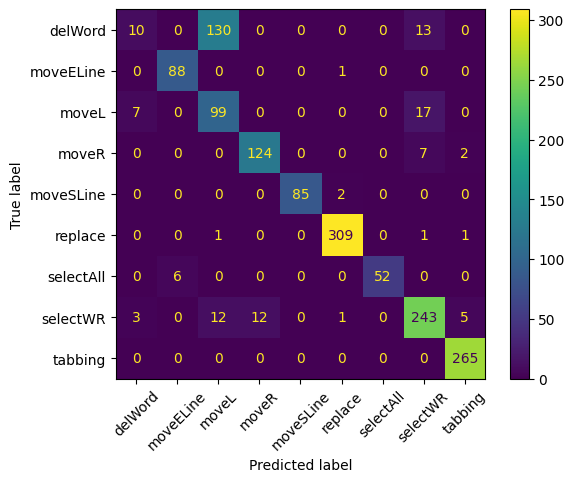

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Used to calculate the confusion matrix
y_true = []
y_pred = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(Y))
disp.plot()
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.75
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))


plt.show()

In [31]:
torch.save(model.state_dict(), "./models/modelSel")

In [43]:
loading = torch.load("./models/modelSel")

In [44]:
model = NeuralNetwork()
model.load_state_dict(loading)
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_tanH_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=9, bias=True)
  )
)

[6]
[8]
[5]
[6]
[6]
[1]
[8]
[8]
[2]
[0]
[7]
[5]
[5]
[5]
[2]
[8]
[3]
[3]
[3]
[5]
[2]
[4]
[0]
[5]
[5]
[3]
[5]
[3]
[8]
[5]
[7]
[5]
[7]
[8]
[8]
[8]
[5]
[8]
[8]
[3]
[1]
[8]
[8]
[8]
[2]
[7]
[2]
[1]
[5]
[7]
[2]
[8]
[1]
[5]
[2]
[1]
[8]
[2]
[8]
[5]
[7]
[7]
[7]
[6]
[7]
[8]
[5]
[4]
[5]
[8]
[8]
[3]
[3]
[7]
[2]
[2]
[3]
[8]
[8]
[8]
[3]
[8]
[5]
[5]
[7]
[5]
[1]
[4]
[5]
[8]
[2]
[3]
[5]
[2]
[1]
[1]
[5]
[4]
[5]
[7]
[5]
[7]
[8]
[7]
[1]
[8]
[3]
[6]
[3]
[7]
[7]
[3]
[5]
[2]
[2]
[2]
[5]
[2]
[7]
[2]
[8]
[5]
[8]
[5]
[8]
[2]
[7]
[5]
[7]
[8]
[5]
[5]
[4]
[8]
[7]
[8]
[4]
[5]
[5]
[6]
[7]
[5]
[4]
[0]
[3]
[5]
[5]
[5]
[5]
[5]
[7]
[5]
[3]
[8]
[2]
[1]
[8]
[6]
[8]
[1]
[2]
[8]
[1]
[5]
[7]
[5]
[4]
[8]
[3]
[8]
[5]
[5]
[2]
[2]
[8]
[5]
[7]
[2]
[7]
[3]
[3]
[7]
[7]
[2]
[2]
[3]
[6]
[6]
[8]
[7]
[1]
[5]
[5]
[1]
[5]
[5]
[2]
[8]
[7]
[5]
[8]
[5]
[3]
[8]
[1]
[7]
[2]
[1]
[6]
[7]
[3]
[7]
[3]
[8]
[7]
[5]
[4]
[6]
[5]
[7]
[6]
[3]
[7]
[8]
[7]
[8]
[6]
[1]
[7]
[7]
[3]
[5]
[5]
[5]
[1]
[5]
[2]
[3]
[6]
[7]
[7]
[7]
[4]
[3]
[2]
[8]
[5]
[8]
[3]
[1]


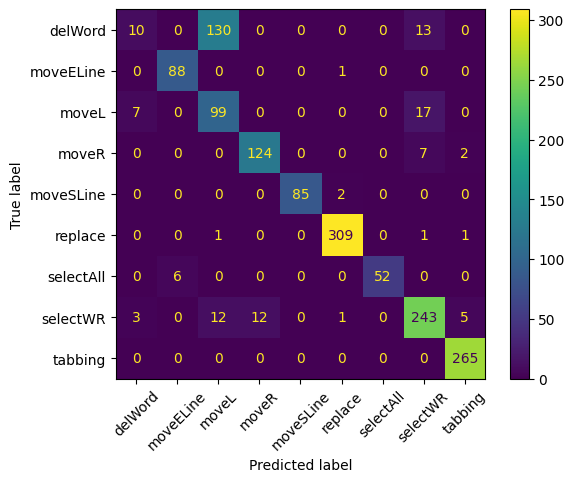

In [48]:
#Used to calculate the confusion matrix
y_true = []
y_pred = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(Y))
disp.plot()
plt.xticks(rotation=45)
plt.show()